## 1. Check values of eigenvalues v! What is the sifference between eigenvalues and singularvalues?
## 2. Make a huge matrix instead of many 2x2 matrices?
## 3. Compare with previous method

In [1]:
%pylab inline
import biff
import matplotlib.patheffects as path_effects

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [3]:
coeff_c = np.loadtxt('../data/bootstrap_mwlmc_1e6_b1_test/coeff_rand_mwlmc5_b1_2_1E6_00000.txt')
S = coeff_c[:,0]
T = coeff_c[:,1]
nmax = 21
lmax = 21

S_matrix = np.zeros((nmax, lmax, lmax))
T_matrix = np.zeros((nmax, lmax, lmax))


counter = 0
for n in range(nmax):
    for l in range(lmax):
        for m in range(0, l+1):
            S_matrix[n][l][m] = S[counter]
            T_matrix[n][l][m] = T[counter]
            counter +=1

In [3]:
cov_c = np.loadtxt('../data/bootstrap_mwlmc_1e6_b1_test/cov_matrix_rand_mwlmc5_b1_2_1E6_00000.tx')
SS = cov_c[:,0]
TT = cov_c[:,1]
ST = cov_c[:,2]
nmax = 21
lmax = 21

SS_matrix = np.zeros((nmax, lmax, lmax))
TT_matrix = np.zeros((nmax, lmax, lmax))
ST_matrix = np.zeros((nmax, lmax, lmax))


counter = 0
for n in range(nmax):
    for l in range(lmax):
        for m in range(0, l+1):
            SS_matrix[n][l][m] = SS[counter]
            TT_matrix[n][l][m] = TT[counter]
            ST_matrix[n][l][m] = ST[counter]
            counter +=1

## 1 Compute covariance Matrix:  cov = ((<x^2> - <x>^2, <xy> - <x><y>), (<yx> - <y><x>, <y^2> - <y>^2))

#### 2 Diagonalize the covariance matrix using an eigensolver.  Use SVD for this, but since the covariance matrix is real
#### symmetric, many approaches are available.   This gives the unitary
#### transformation, *T*, to new basis that is uncorrelated.  The eigenvalues
#### *ß* are the diagonal covariance (or now, variance) elements.


#### 3 In this new basis, the uncorrelated coefficients are *c* = *T* ∙ *a,
#### *and the smoothing coefficients are b_j = 1/(1 + ß_j/c_j^2).  The
#### smoothed coefficients are now *d* = *b ∘ c * (where ∘ is the Hadamard
#### product)

#### 4 Apply the Hall smoothing in this uncorrelated basis.  Then perform
#### the inverse transformation back to the original basis: *a' = T^*{-1}∙
#### *d*.  That is, *a'* is now the Hall smoothed coefficients in the
#### original basis.*

In [126]:
def covariance_matrix(S, T, SS, TT, ST, mass):
    """
    Construct the covariance matrix
    
    Input:
    ------
    
    Parameters:
    ----------
    S
    T
    SS
    TT
    ST
    mass : 
    
    
    """
    
    cov_matrix = np.zeros((2,2))
    cov_matrix[0][0] = SS - mass*S**2 
    cov_matrix[0][1] = ST - mass*S*T 
    cov_matrix[1][1] = TT - mass*T**2 
    cov_matrix[1][0] = ST - mass*S*T 
    
    return cov_matrix

def smoothing(S, T, varS, varT):
    """
    Computes optimal smoothing following Eq.8 in Weinberg+96.
    
    returns:
    --------
    
    bs
    bt : 
    """
    bs = 1 / (1 + (varS/S**2))
    bt = 1 / (1 + (varT/T**2))
    if S == 0:
        bs=0
    if T == 0:
        bt=0
    return bs, bt
    
def smoothed_coeff_correlated(cov_matrix, S, T, verb=False):
    
    # SVD decomposition of the covariance matrix
    T_rot, v, TL = linalg.svd(cov_matrix)
    
    # Computes inverted transformation matrix
    T_rot_inv = linalg.inv(T_rot)

    # Variances of the coefficients in the uncorrelated base.
    varS = v[0]
    varT = v[1]
    
    ## uncorrelated coefficients
    coeff_base = np.array([S, T])
    S_unc, T_unc = np.dot(T_rot, coeff_base)
    b_S_unc, b_T_unc = smoothing(S_unc, T_unc, varS, varT)
    S_unc_smooth = S_unc*b_S_unc
    T_unc_smooth = T_unc*b_T_unc
    SN_coeff_unc = (S_unc**2/varS)**0.5
    S_smooth, T_smooth = np.dot(T_rot_inv, np.array([S_unc_smooth, T_unc_smooth]))
    
    if verb==True:
        print("S,T  correlated = ", S, T)
        print("S,T uncorrelated = ", S_unc, T_unc)
        print("Uncorrelated smoothing = ", b_S_unc, b_T_unc)
        print("Uncorrelated S/N=", SN_coeff_unc)
        print("S, T uncorrelated smoothed =", S_unc_smooth, T_unc_smooth)
            
    return S_smooth, T_smooth

def smooth_coeff(S, T, SS, TT, ST, mass, verb=False):
    cov_matrix = covariance_matrix(S, T, SS, TT, ST, mass)
    S_smooth, T_smooth = smoothed_coeff_correlated(cov_matrix, S, T, verb)
    
    return S_smooth, T_smooth

def smooth_coeff_matrix(S, T, SS, TT, ST, mass, nmax, lmax, mmax):
    S_matrix_smooth = np.zeros((nmax+1, lmax+1, lmax+1))
    T_matrix_smooth = np.zeros((nmax+1, lmax+1, lmax+1))

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                S_matrix_smooth[n][l][m], T_matrix_smooth[n][l][m] = smooth_coeff(S[n][l][m],
                                                                                  T[n][l][m], 
                                                                                  SS[n][l][m], 
                                                                                  TT[n][l][m],
                                                                                  ST[n][l][m],
                                                                                  mass)
                
    return S_matrix_smooth, T_matrix_smooth


def smoothing_biased(cov_matrix, coeff, m):
    """
    Coefficients smoothing 
    
    """
    var_coeff = ((cov_matrix - m*coeff**2))
    b_nlm = 1/(1 + var_coeff/coeff**2)
    #if coeff == 0:
    #    b_nlm=0
    #if b_nlm <= 0.3:
    #    b_nlm=0
    # This line remove nans an put the original values
    b_nlm_values = np.nan_to_num(b_nlm)
    return b_nlm_values

def smooth_coeff_matrix_biased(S, T, SS, TT, mass, nmax, lmax, mmax):
    S_matrix_smooth = np.zeros((nmax+1, lmax+1, lmax+1))
    T_matrix_smooth = np.zeros((nmax+1, lmax+1, lmax+1))

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                S_matrix_smooth[n][l][m] = smoothing_biased(SS[n][l][m], S[n][l][m], mass)*S[n][l][m]
                T_matrix_smooth[n][l][m] = smoothing_biased(TT[n][l][m], T[n][l][m], mass)*T[n][l][m]
                
    return S_matrix_smooth, T_matrix_smooth

In [127]:
n = 0
l = 0
m = 0

In [3]:
mass = 1.577212515257997438e-06

In [129]:
shape(S_matrix)

(21, 21, 21)

In [130]:
# Computing smoothed coefficients by transfrming to the principal basis
S_matrix_smooth, T_matrix_smooth = smooth_coeff_matrix(S_matrix, T_matrix, SS_matrix, TT_matrix, ST_matrix, mass, 20, 20, 20)

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


In [131]:
# Computing smoothed coefficients in the current basis 
S_matrix_smooth_biased, T_matrix_smooth_biased = smooth_coeff_matrix_biased(S_matrix, T_matrix, SS_matrix, TT_matrix, mass, 20, 20, 20)

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


In [132]:
print(S_matrix[n][l][m], S_matrix_smooth[n][l][m], S_matrix_smooth_biased[n][l][m])

1.599363531926 1.5993633951210307 1.5993636687309927


In [133]:
smoothing_biased(SS_matrix[0,0,0], S_matrix[0,0,0], mass)
 

1.0000000855371465

In [134]:
SS_matrix[0,0,0]

3.815651474907e-06

In [146]:
n = 0
l = 20
m = 0

In [147]:
smooth_coeff(S_matrix[n][l][m], T_matrix[n][l][m], SS_matrix[n][l][m], TT_matrix[n][l][m], ST_matrix[n][l][m], mass, verb=True)

S,T  correlated =  510819.2822082 -0.0
S,T uncorrelated =  510819.2822082 0.0
Uncorrelated smoothing =  0.008140791839811935 0
Uncorrelated S/N= 0.09059585128604235
S, T uncorrelated smoothed = 4158.473444219105 0.0


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


(4158.473444219105, 0.0)

In [81]:
### smoothed densities comparisson:
    

In [82]:
y_grid = np.arange(-300, 300, 5.5)
z_grid = np.arange(-300, 300, 5.5)
y_grid, z_grid = meshgrid(y_grid, z_grid)

xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                     y_grid.flatten(), z_grid.flatten()]).T)

In [83]:
S_000 = np.zeros((1, 1, 1))
T_000 = np.zeros((1, 1, 1))
S_000[0][0][0] = S_matrix[0][0][0]

S_000_smooth = np.zeros((1, 1, 1))
T_000_smooth = np.zeros((1, 1, 1))
S_000_smooth[0][0][0] = S_matrix_smooth[0][0][0]


S_000_smooth_bias = np.zeros((1, 1, 1))
T_000_smooth_bias = np.zeros((1, 1, 1))
S_000_smooth_bias[0][0][0] = S_matrix_smooth_biased[0][0][0]

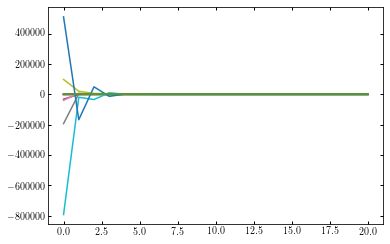

In [84]:
plot(S_matrix[:,:,0])
plot(S_matrix_smooth[:,4,0])
plot(S_matrix_smooth_biased[:,4,0])

In [85]:
S_matrix[:,0,0]

array([ 1.59936353e+00, -7.47854935e-03, -3.56820949e-03,  6.13900997e-04,
        8.30805205e-04,  2.00717736e-04,  6.50413261e-05,  1.03978832e-04,
        3.34331864e-05, -3.40037647e-05, -6.21273027e-05, -2.11035978e-05,
       -3.81075288e-05,  1.11867496e-05, -2.86240258e-06,  2.15826392e-05,
        7.59507719e-06,  1.32824164e-05, -1.92284754e-07, -3.39260748e-06,
       -1.00996229e-05])

In [86]:
print(S_matrix_smooth[0,2,0], S_matrix[0,2,0])

0.02393638947268333 0.02426384587928


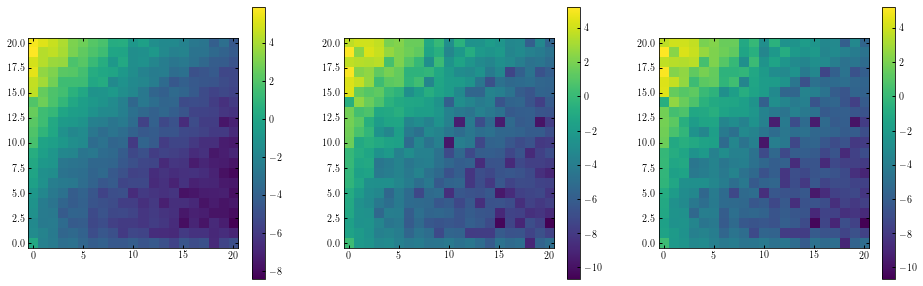

In [87]:
figure(figsize=(16, 5))
subplot(1, 3, 1)
imshow(np.log10(np.abs(S_matrix[:,:,0].T)), origin='lower')
colorbar()

subplot(1, 3, 2)
imshow(np.log10(np.abs(S_matrix_smooth[:,:,0].T)), origin='lower')
xlim(-0.5, 20.5)
ylim(-0.5, 20.5)
colorbar()

subplot(1, 3, 3)
imshow(np.log10(np.abs(S_matrix_smooth_biased[:,:,0].T)), origin='lower')
xlim(-0.5, 20.5)
ylim(-0.5, 20.5)
colorbar()

In [88]:
rho_all = biff.density(xyz, S_matrix, T_matrix, M=1, r_s=40.85)
rho_base = biff.density(xyz, S_000, T_000, M=1, r_s=40.85)

In [89]:
rho_smooth = biff.density(xyz, S_matrix_smooth, T_matrix_smooth, M=1, r_s=40.85)
rho_base_smooth = biff.density(xyz, S_000_smooth, T_000_smooth, M=1, r_s=40.85)

In [90]:
rho_smooth_bias = biff.density(xyz, S_matrix_smooth_biased, T_matrix_smooth_biased, M=1, r_s=40.85)
rho_base_bias = biff.density(xyz, S_000_smooth_bias, T_000_smooth_bias, M=1, r_s=40.85)

In [91]:
bins=110

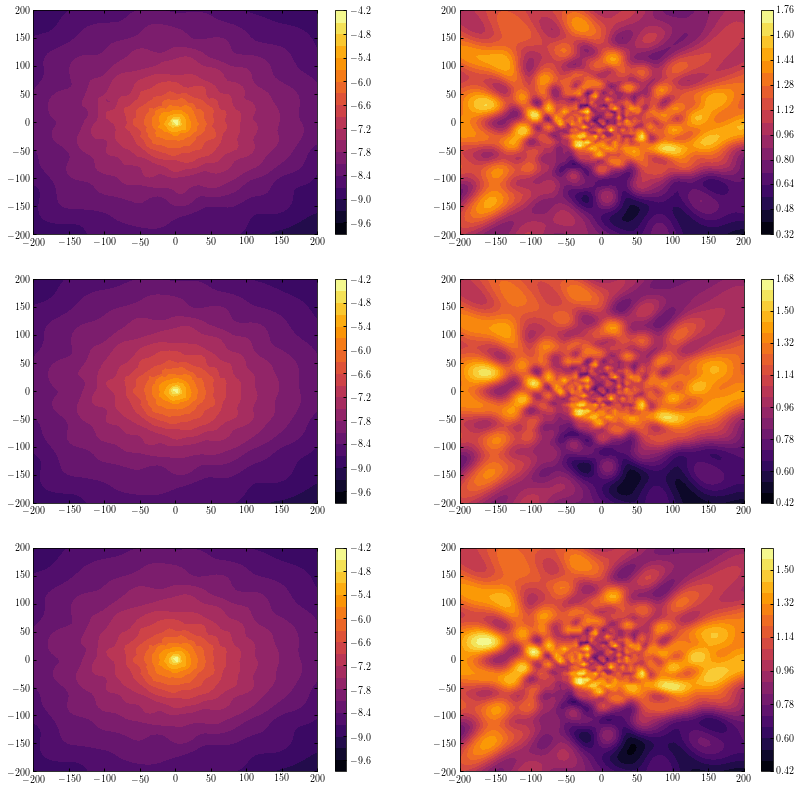

In [92]:
figure(figsize=(14,14))
subplot(3, 2, 1)
contourf(y_grid, z_grid, np.log10(rho_all).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()


subplot(3, 2, 2)
contourf(y_grid, z_grid, (rho_all/rho_base).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()

subplot(3, 2, 3)
contourf(y_grid, z_grid, np.log10(rho_smooth).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()


subplot(3, 2, 4)
contourf(y_grid, z_grid, (rho_smooth/rho_base_smooth).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()


subplot(3, 2, 5)
contourf(y_grid, z_grid, np.log10(rho_smooth_bias).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()


subplot(3, 2, 6)
contourf(y_grid, z_grid, (rho_smooth_bias/rho_base_bias).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
colorbar()


In [93]:
S_000_smooth_bias

array([[[1.59936367]]])

In [98]:
S_matrix_smooth_biased[0,0,0]

0.0

## testing bootstrap

In [4]:
import coefficients_smoothing

In [5]:
y_grid = np.arange(-300, 300, 5.5)
z_grid = np.arange(-300, 300, 5.5)
y_grid, z_grid = meshgrid(y_grid, z_grid)

xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                     y_grid.flatten(), z_grid.flatten()]).T)

In [6]:
bins=110

/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:98: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:179: RuntimeWarning: invalid value encountered in double_scalars
  SN_coeff_unc = (coeff**2/var_coeff)**0.5
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:171: RuntimeWarning: invalid value encountered in double_scalars
  b_nlm = 1/(1 + var_coeff/coeff**2)
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:98: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:179: RuntimeWarning: invalid value encountered in double_scalars
  SN_coeff_unc = (coeff**2/var_coeff)**0.5
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:171: RuntimeWarning: invalid value encountered in double_scalars
  b_nlm = 1/(1 + var_coeff/coeff**2)
/home/xzk/

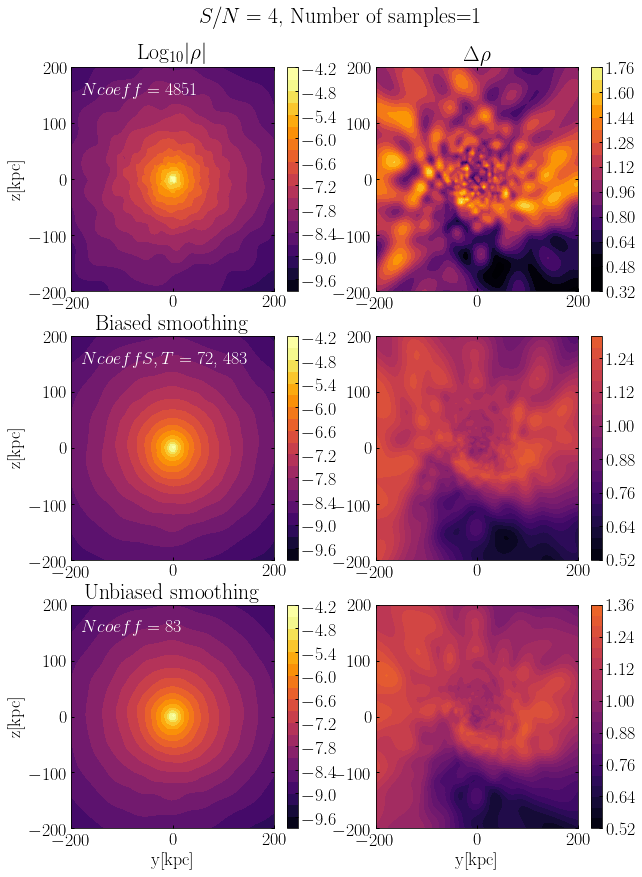

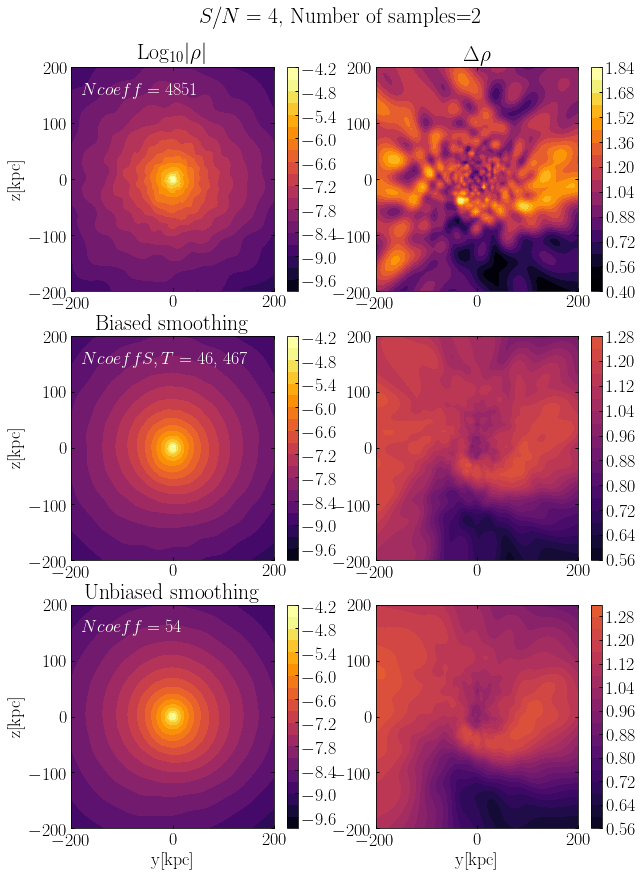

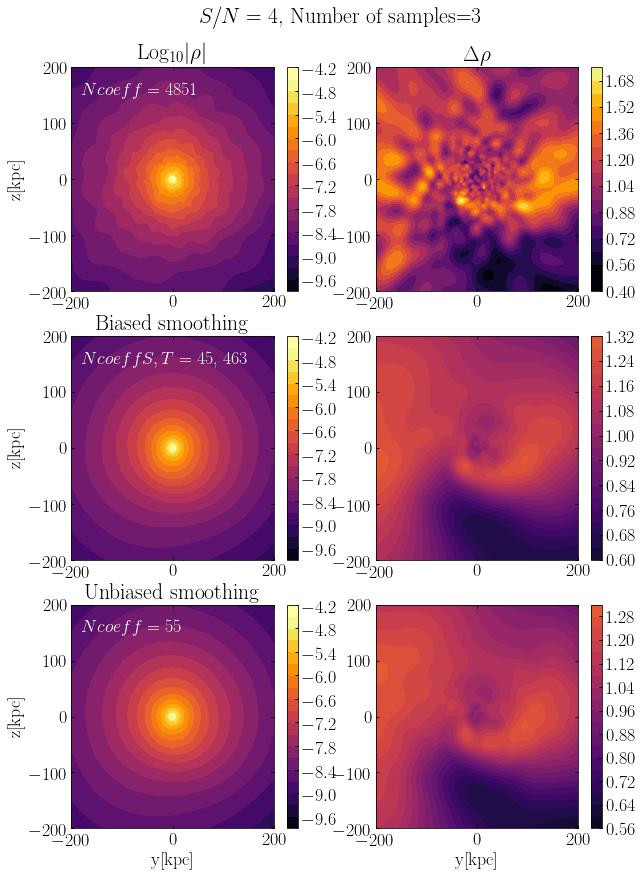

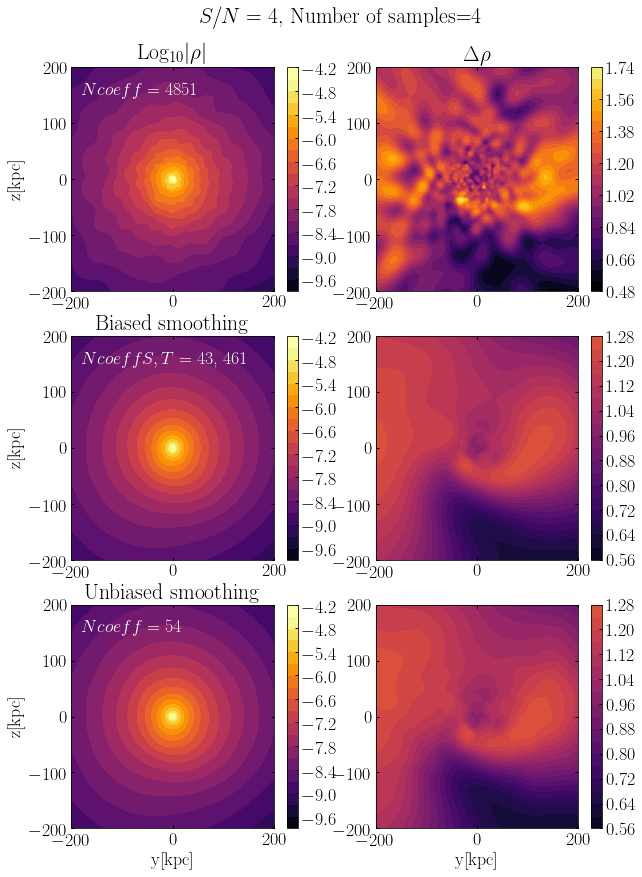

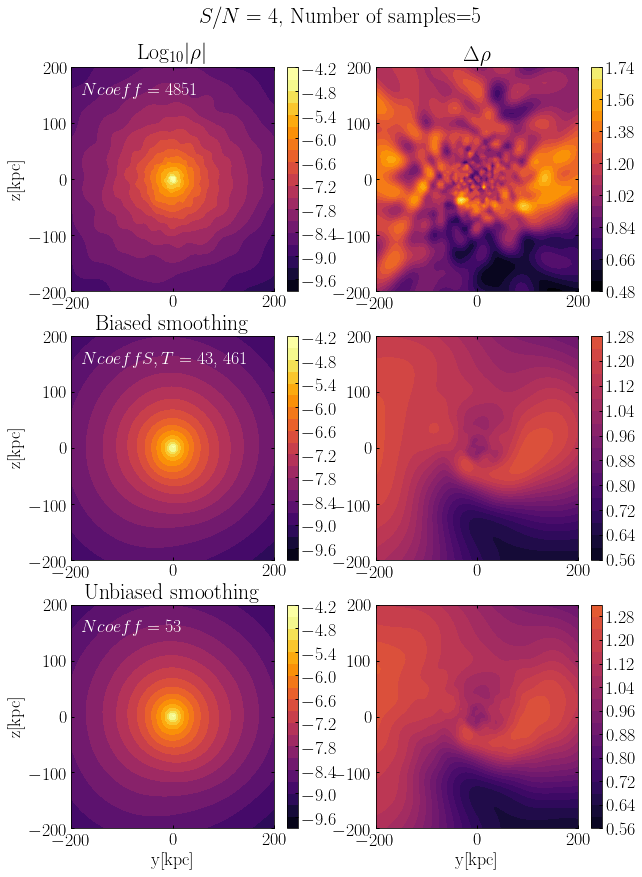

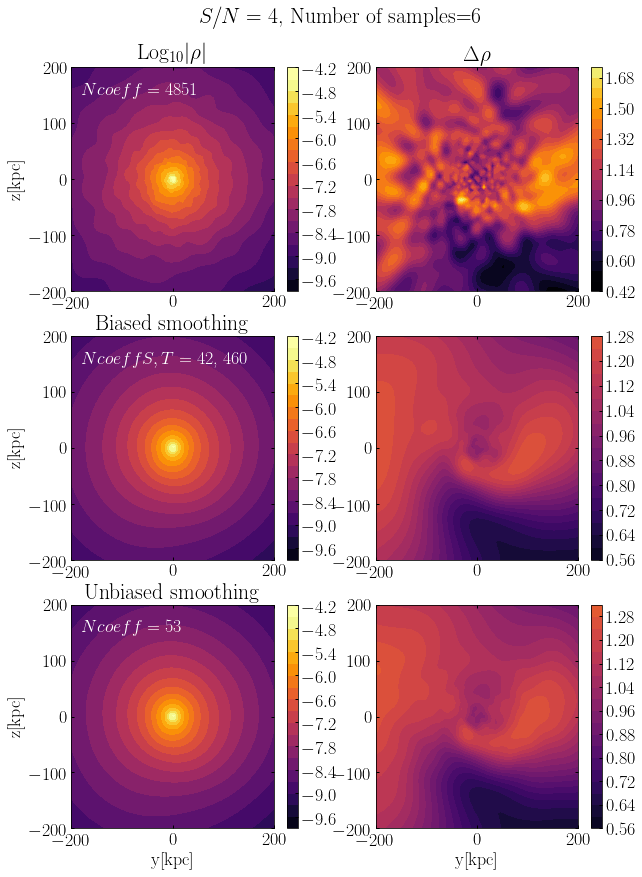

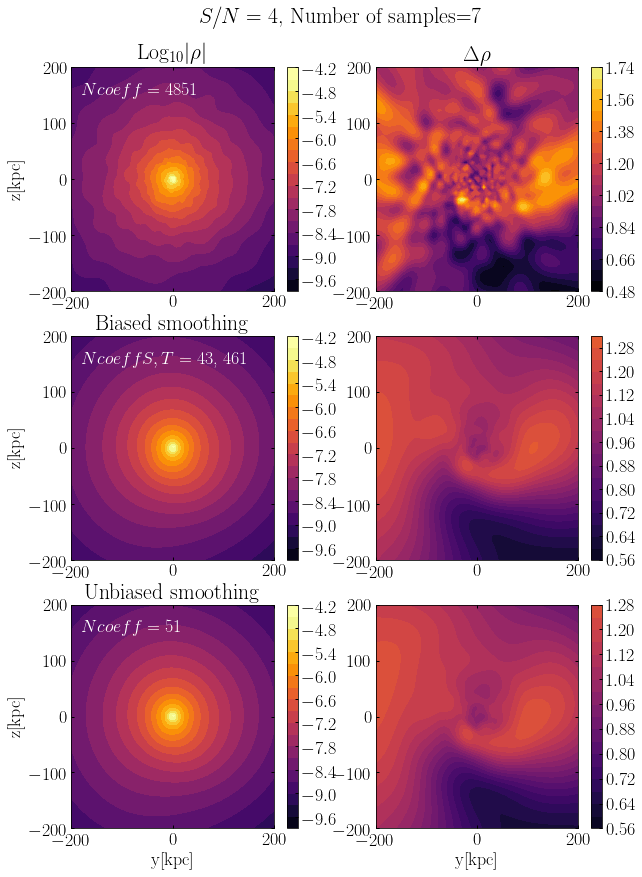

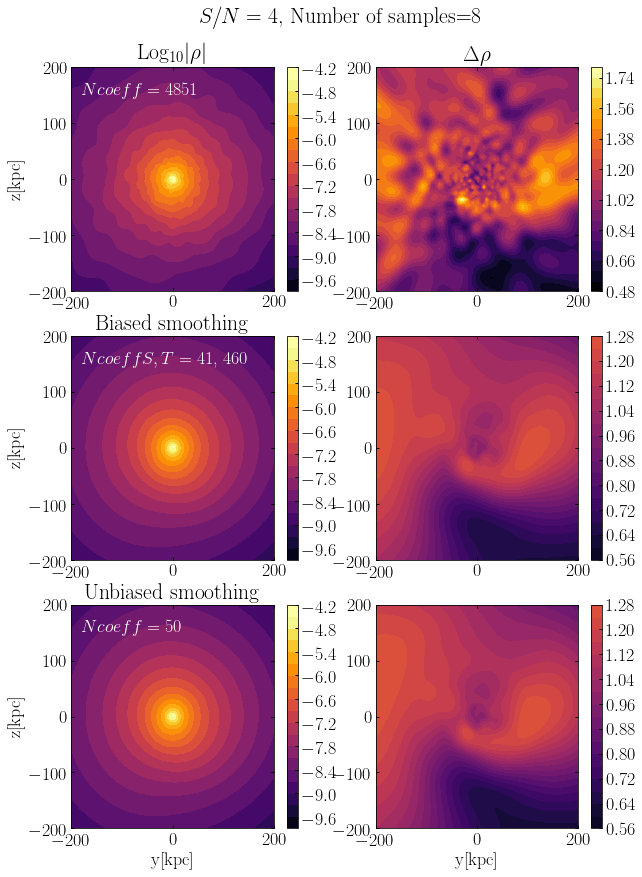

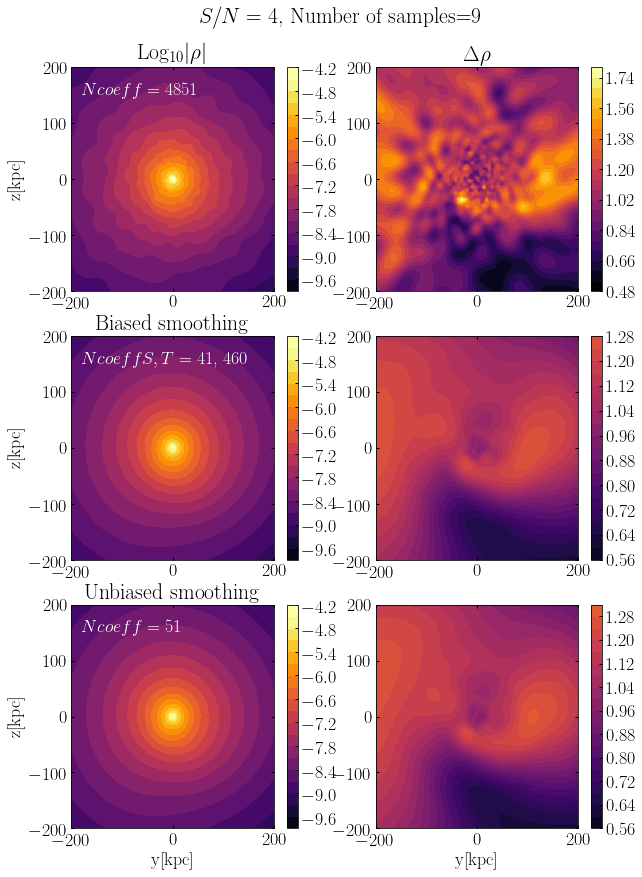

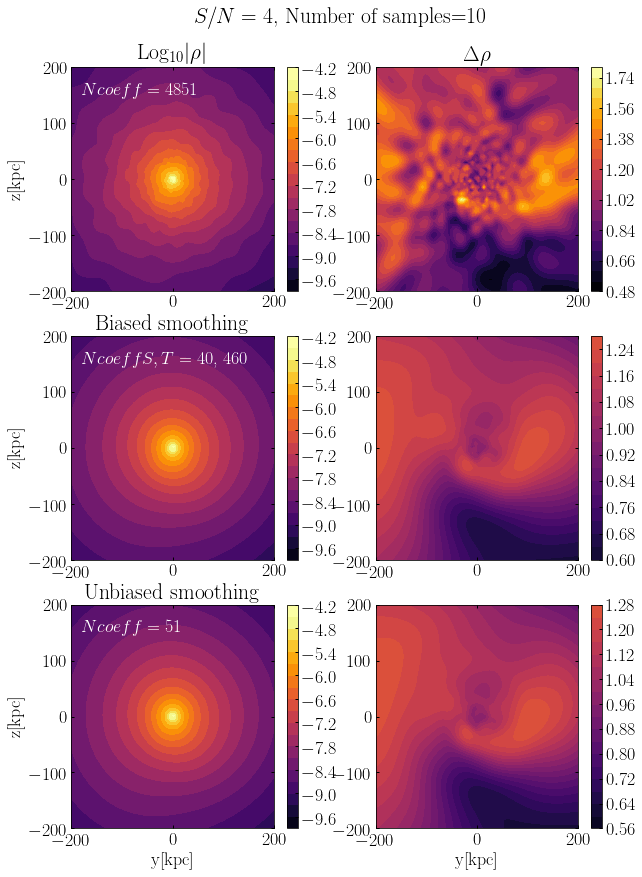

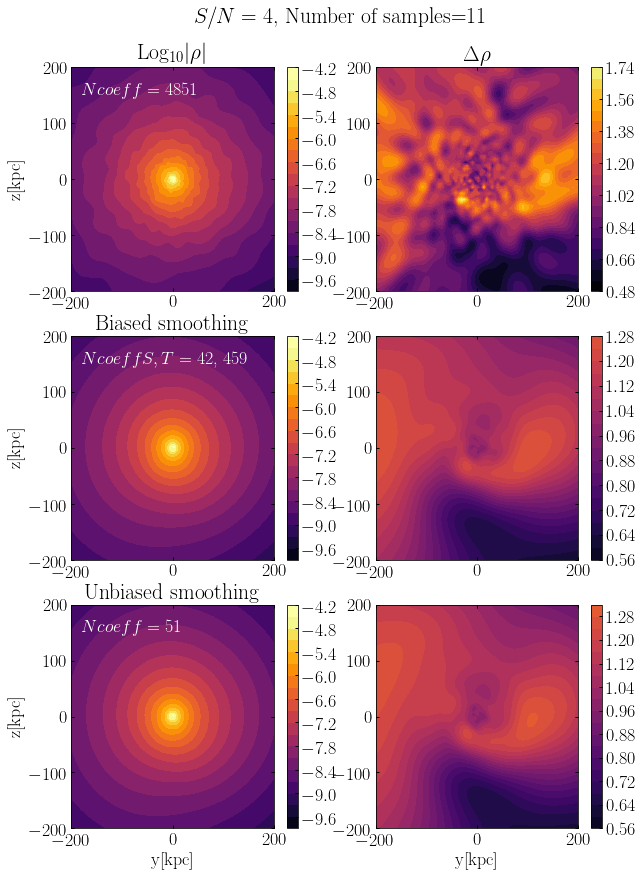

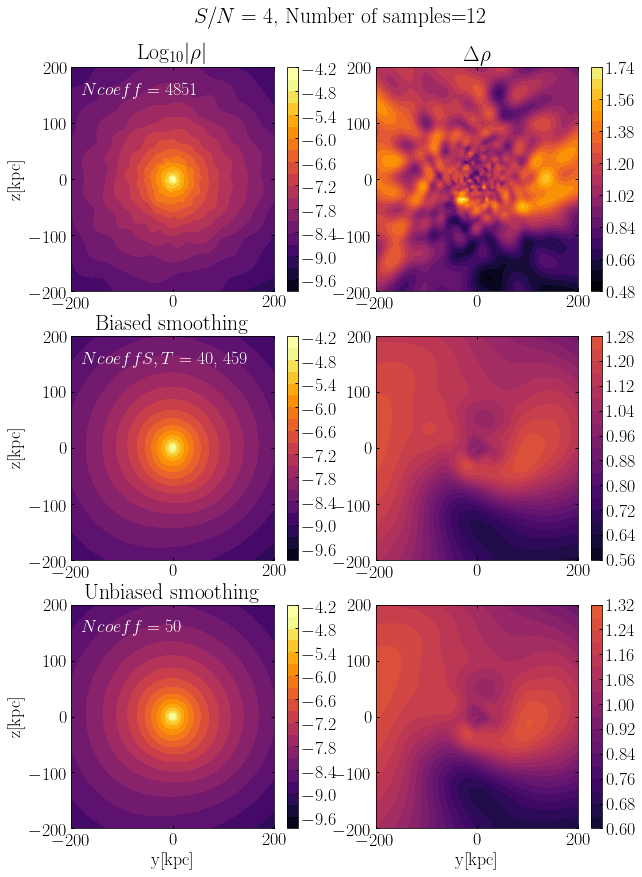

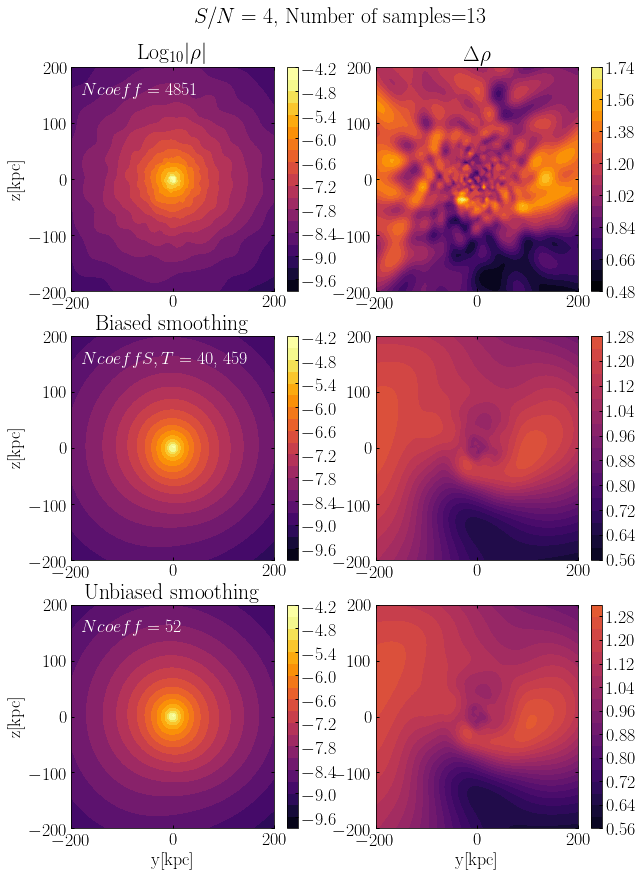

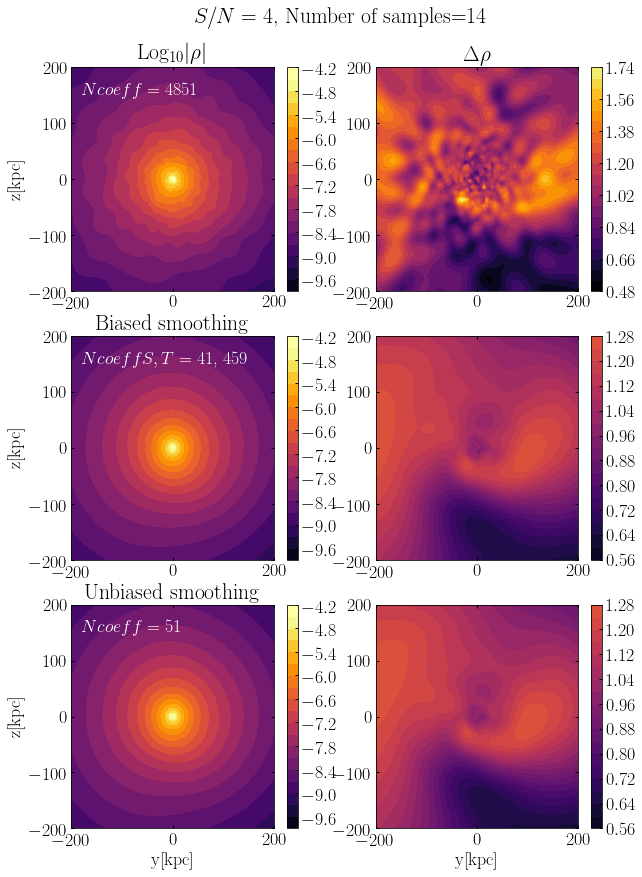

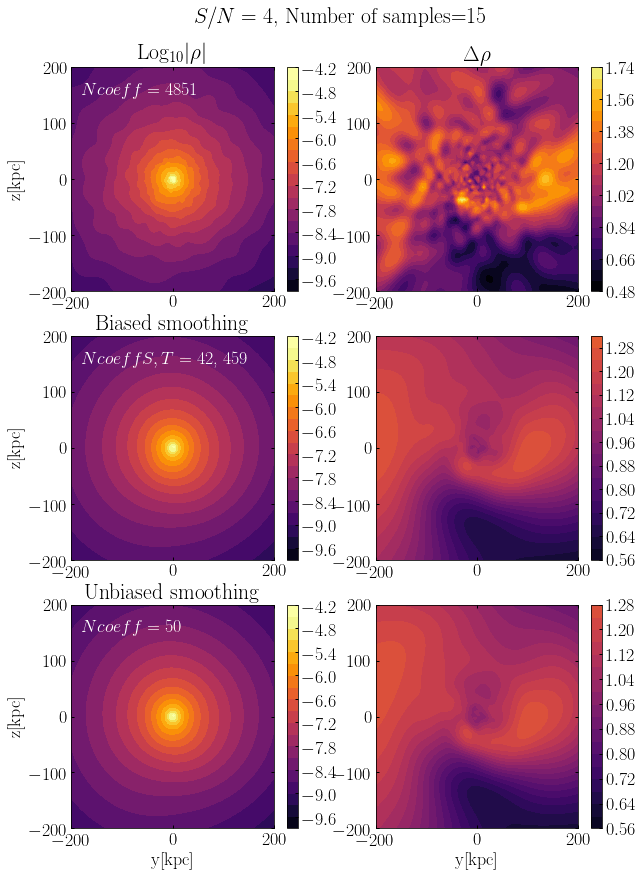

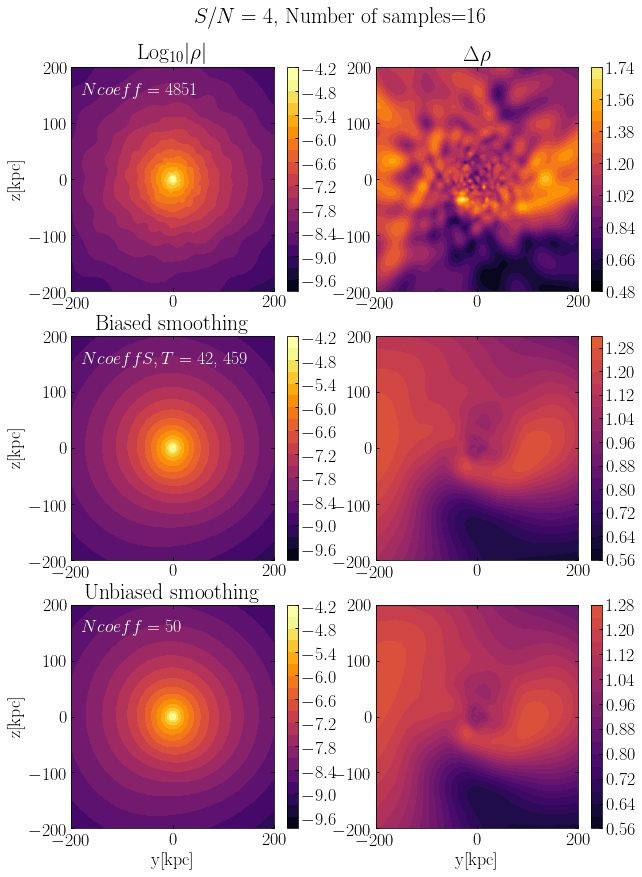

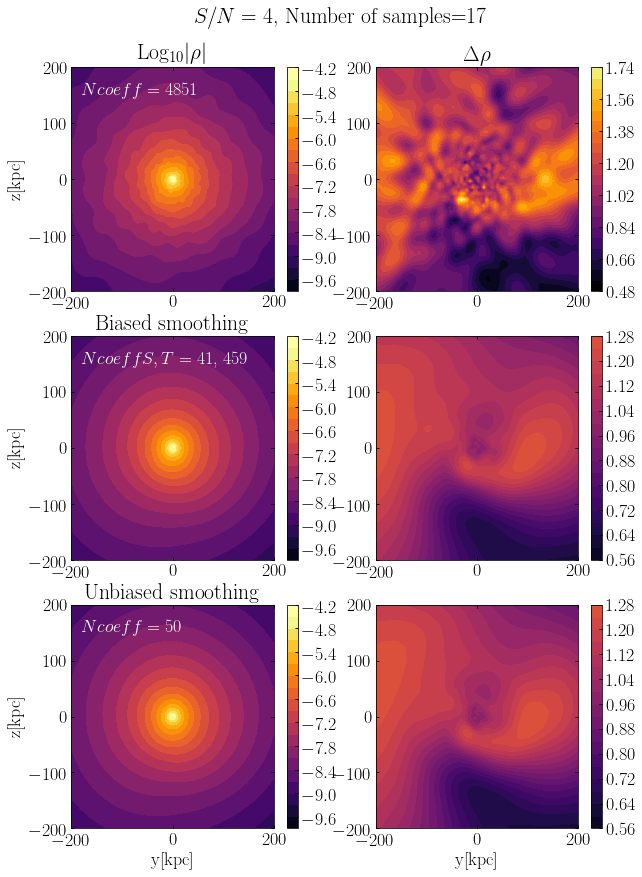

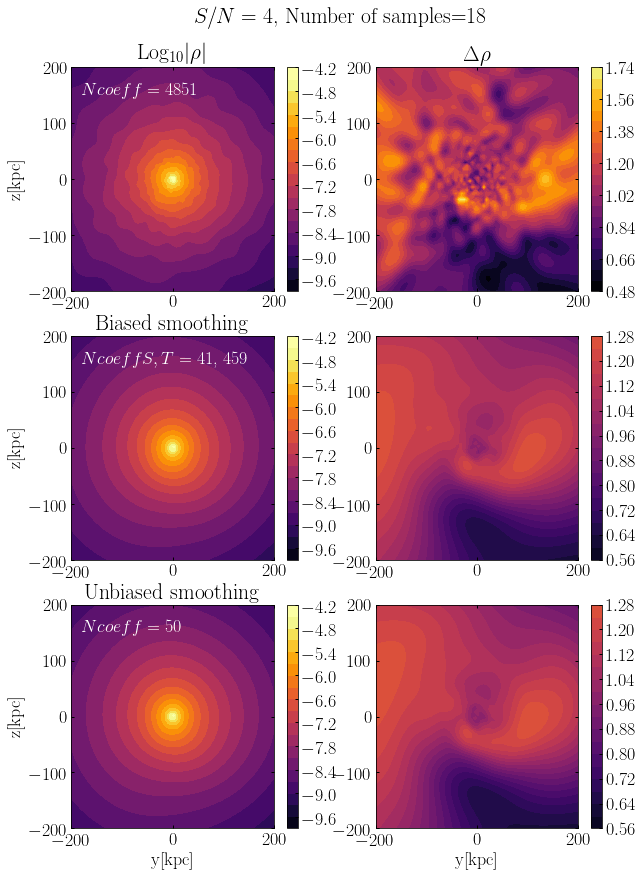

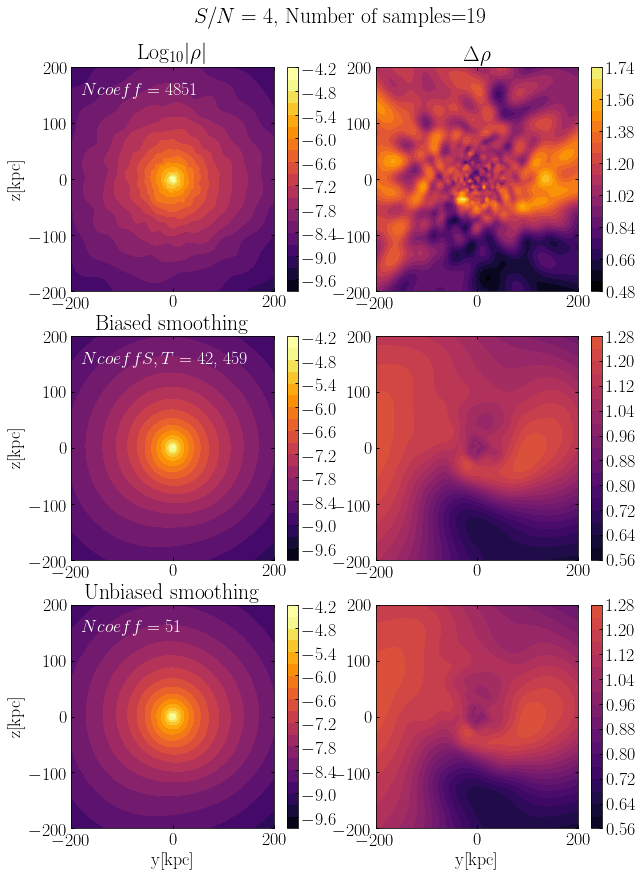

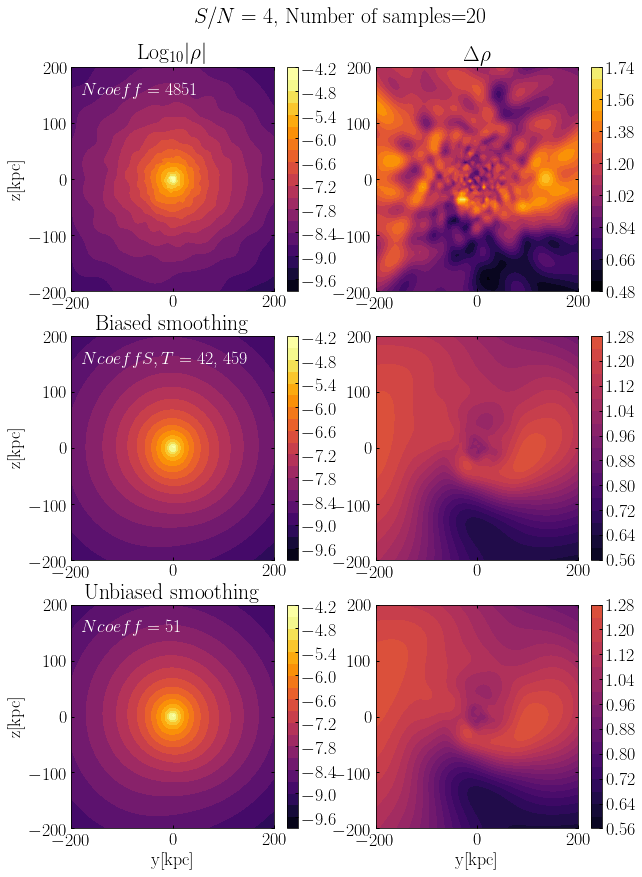

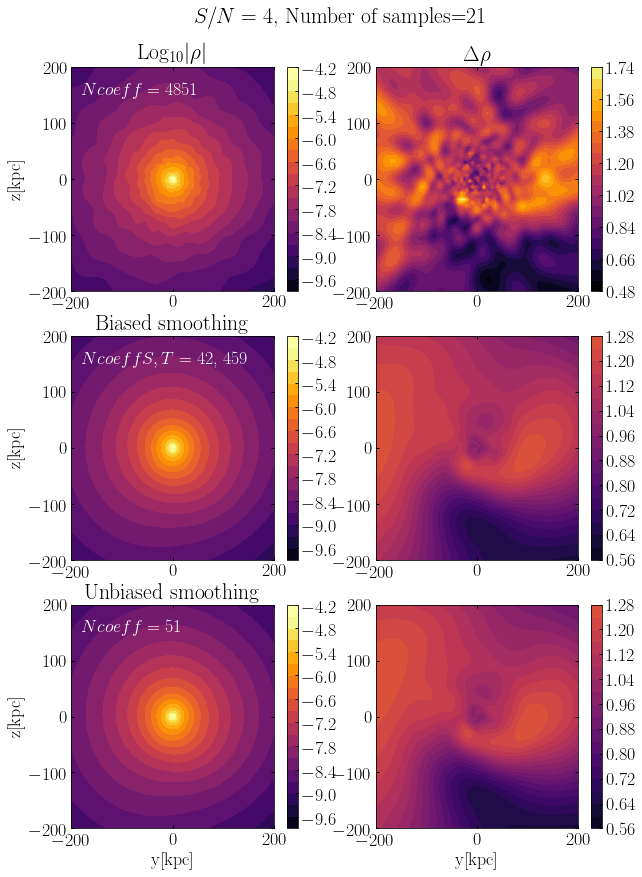

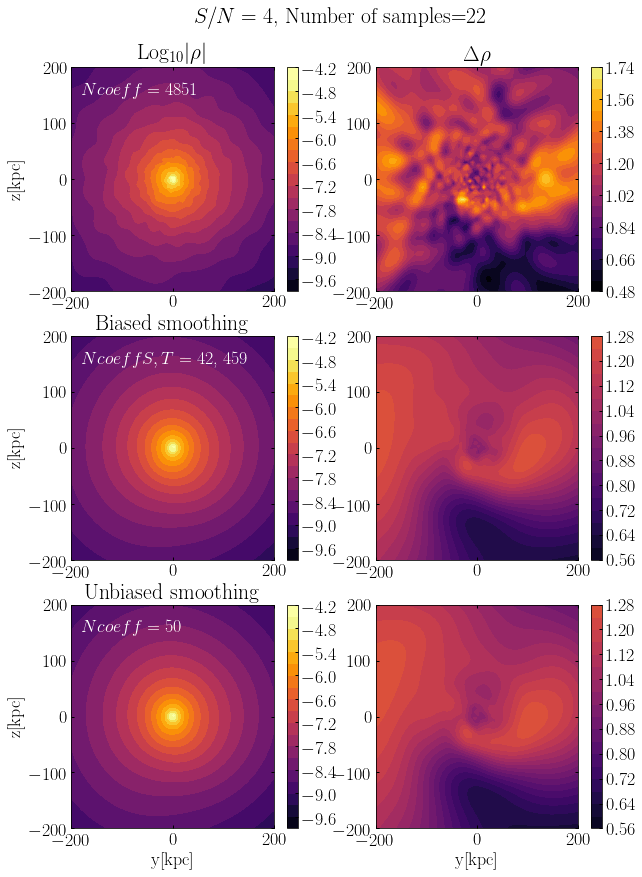

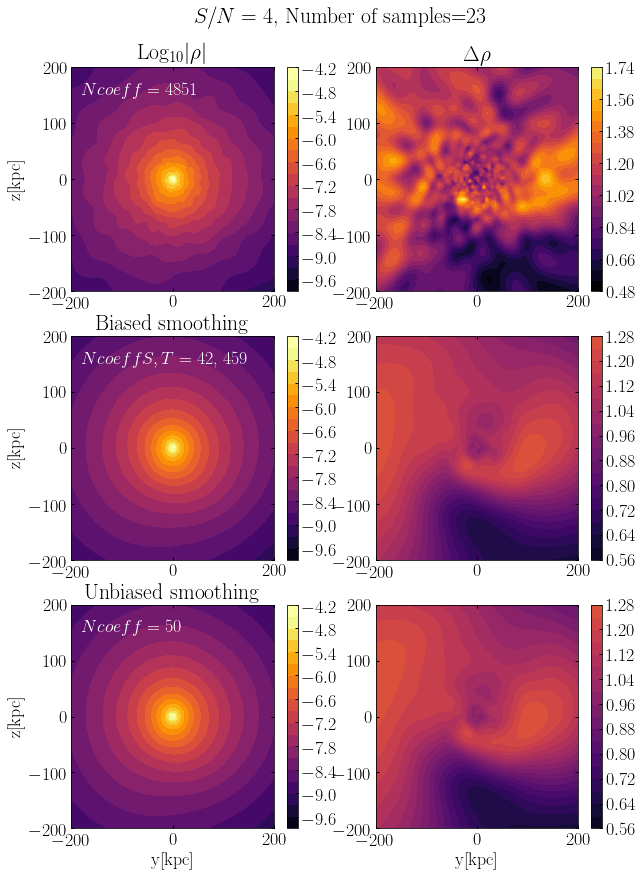

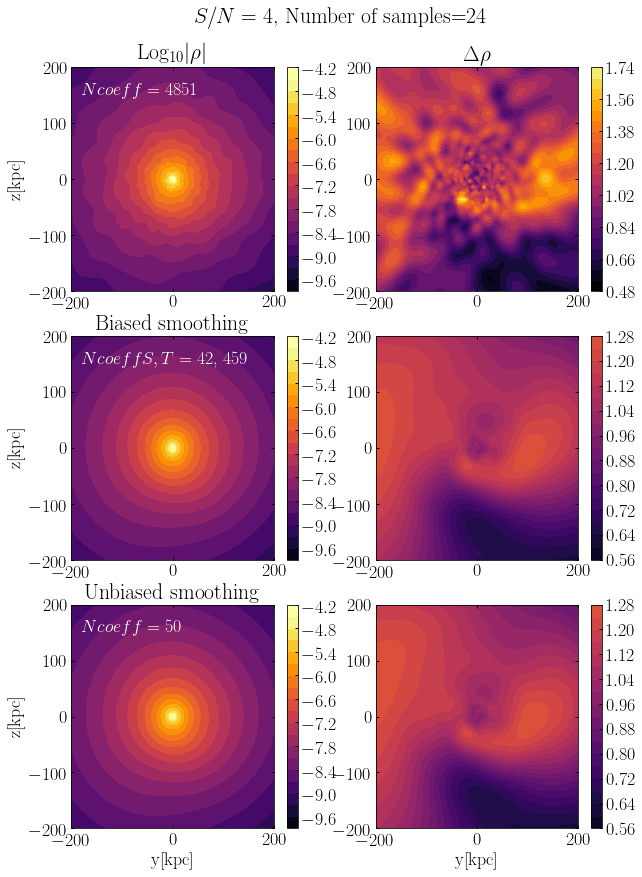

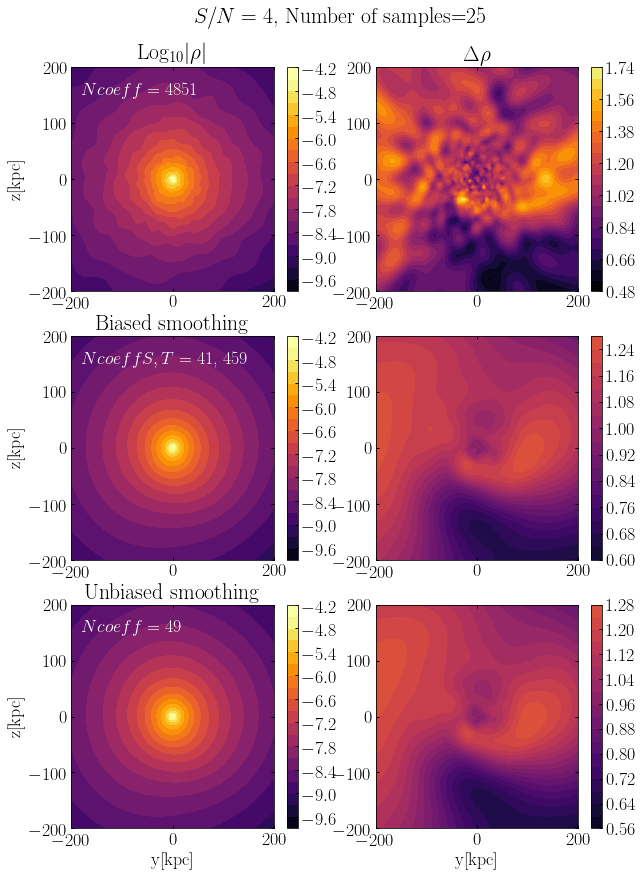

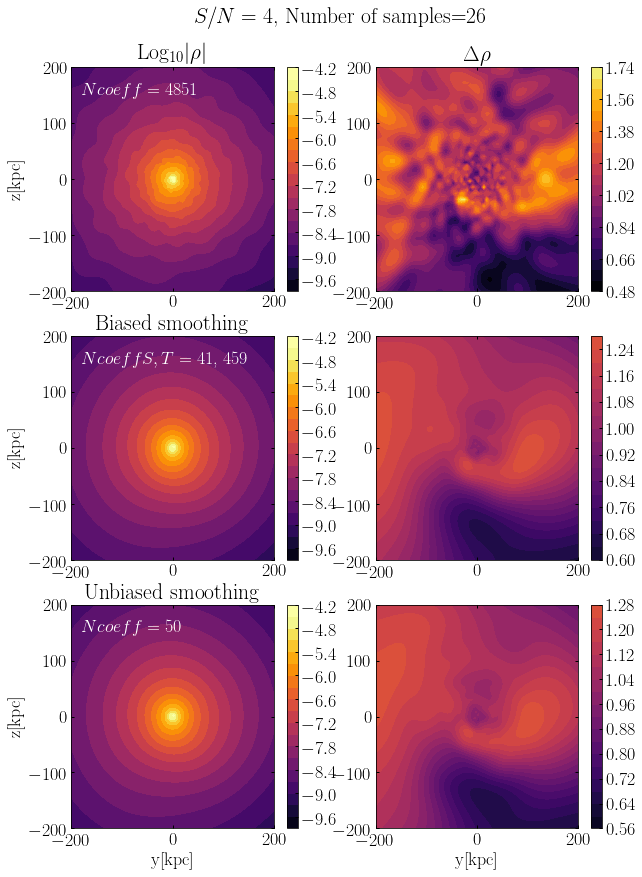

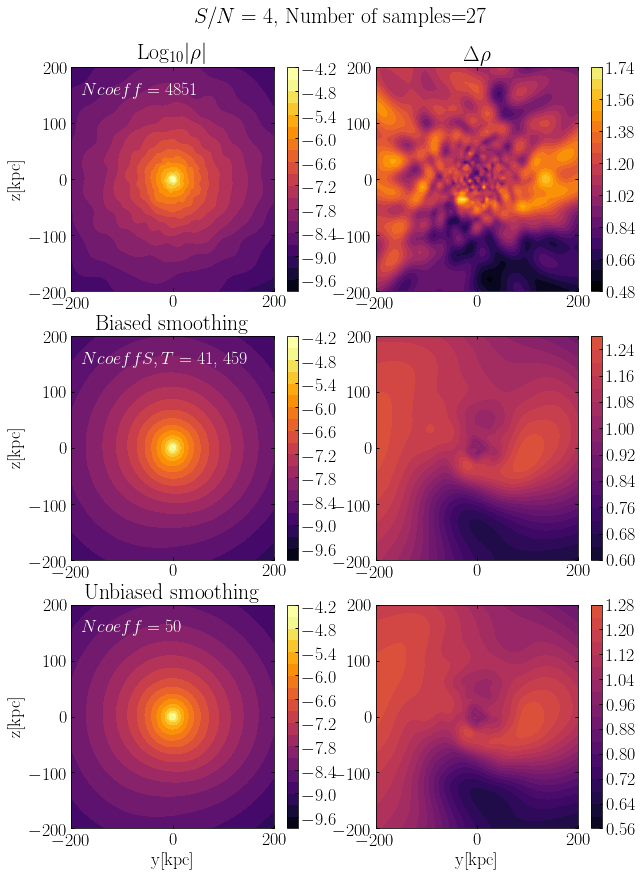

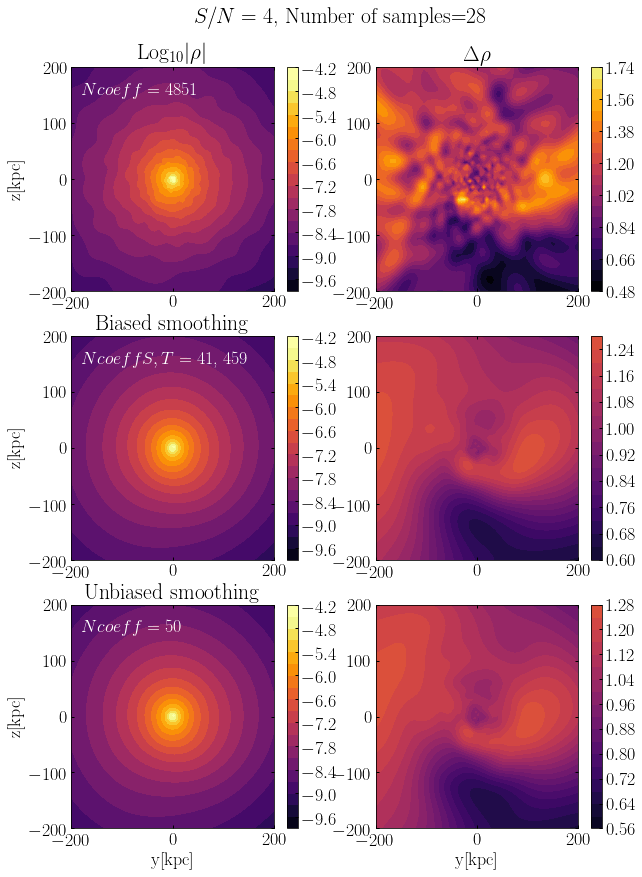

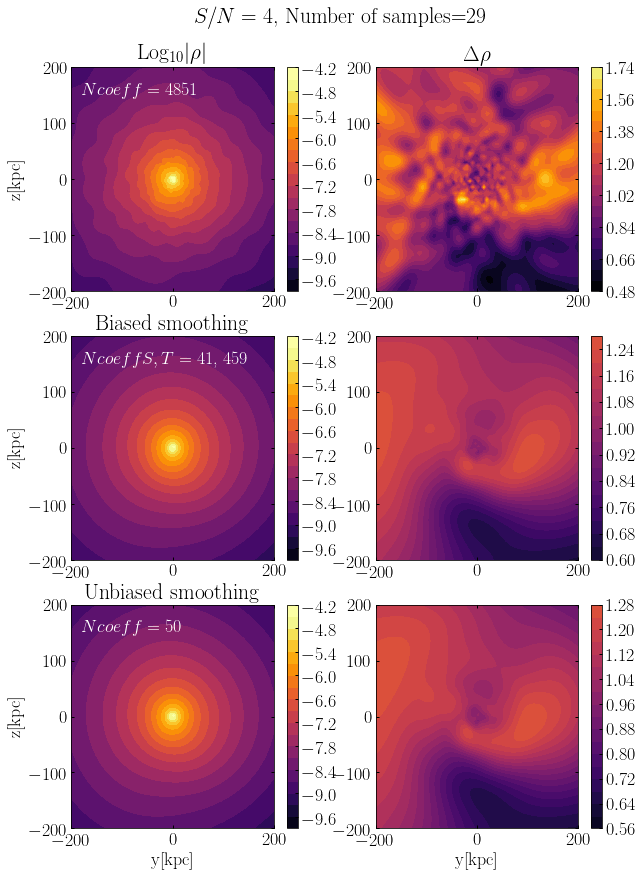

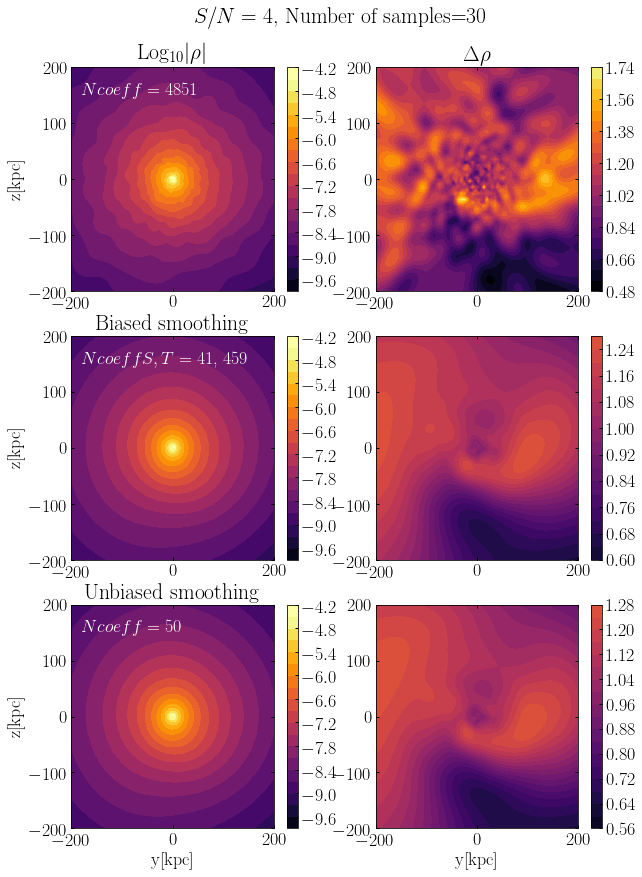

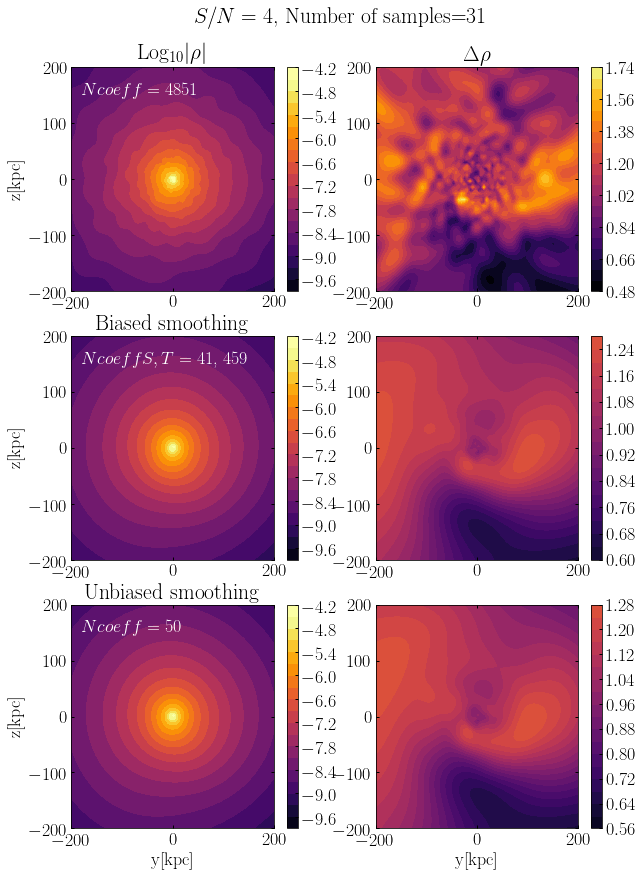

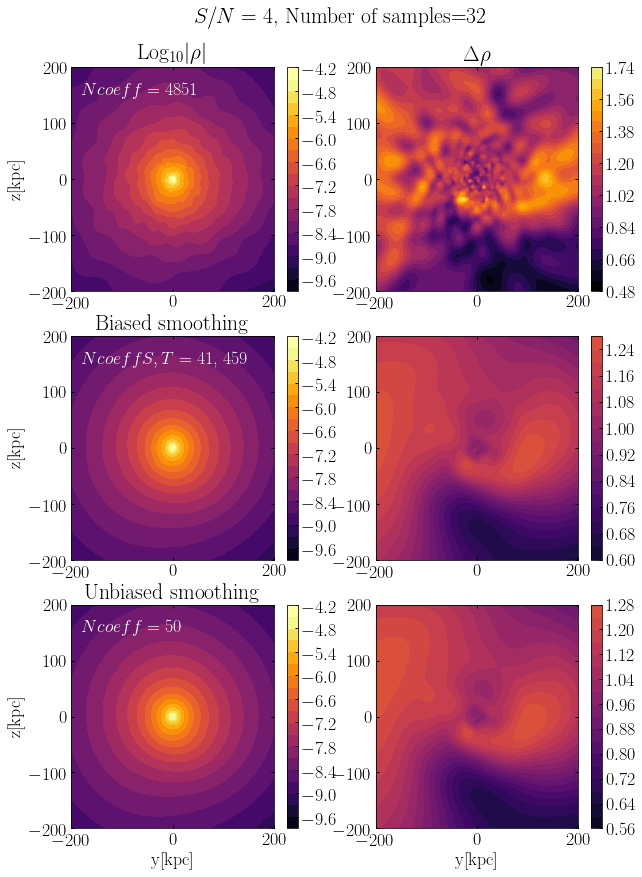

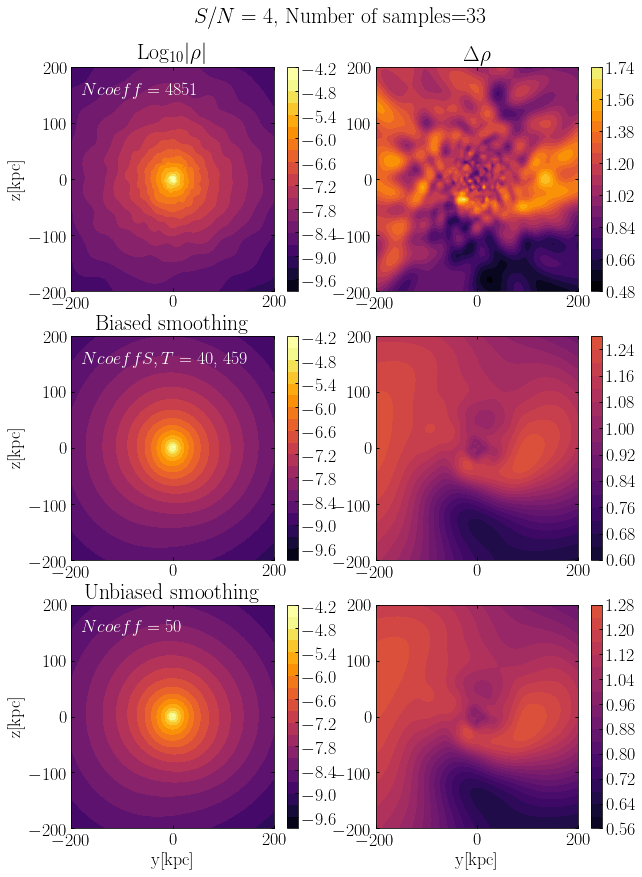

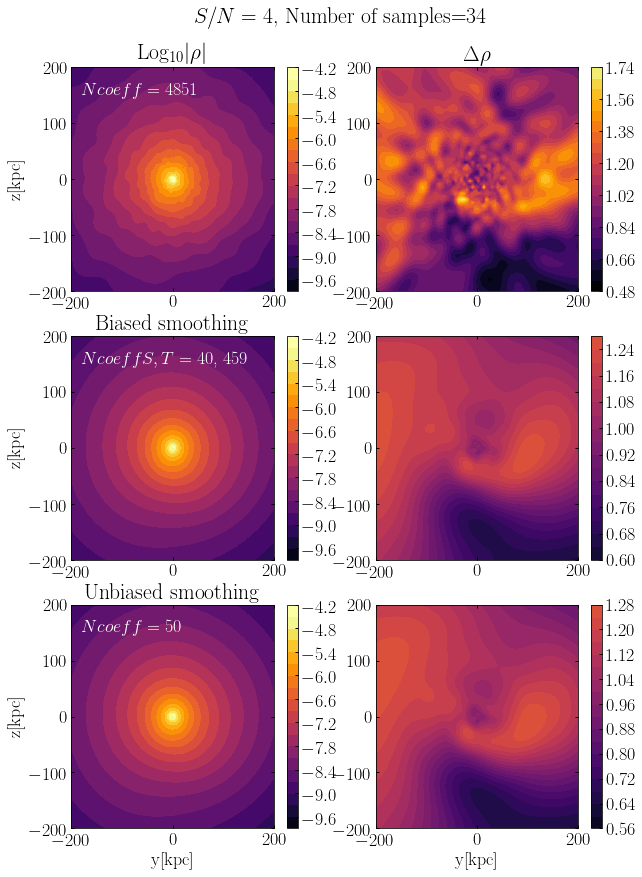

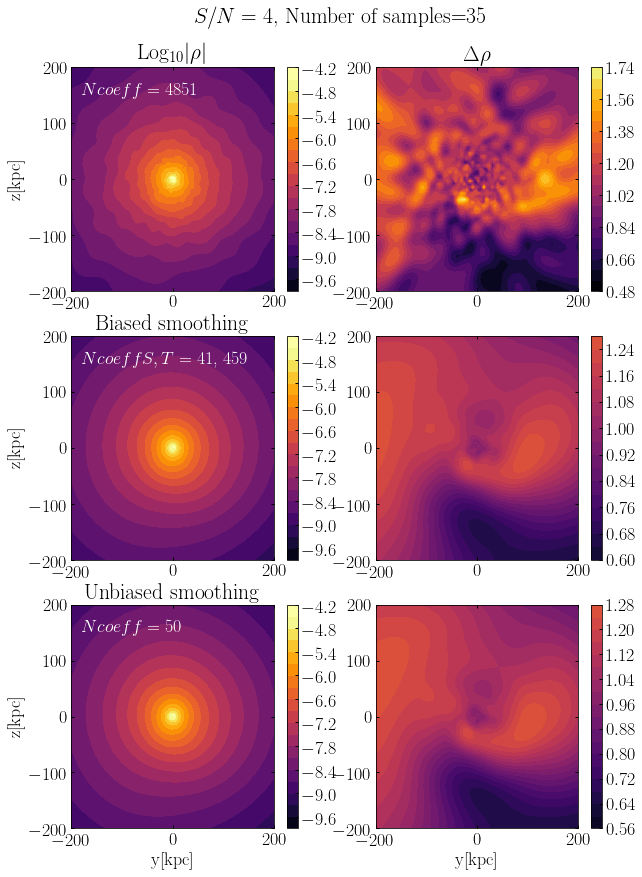

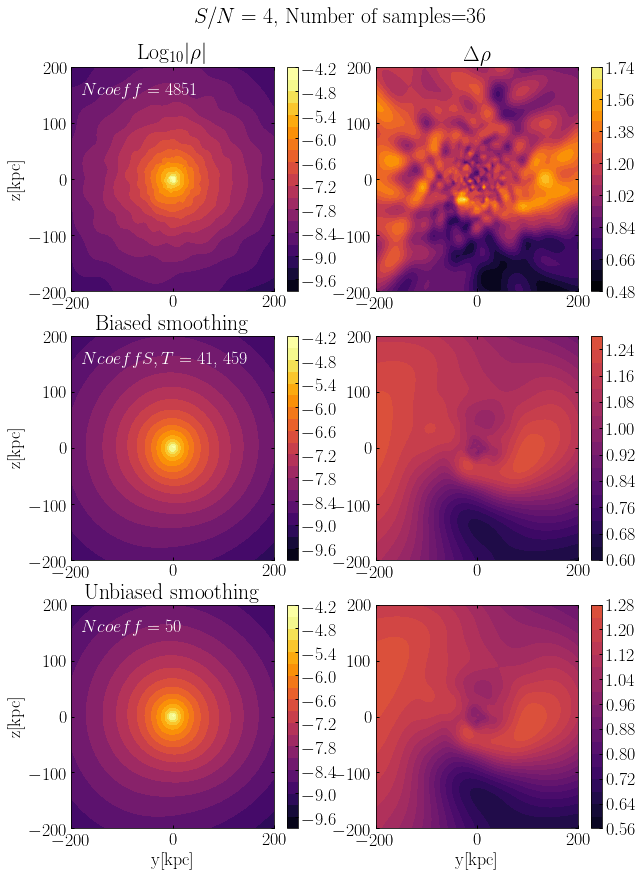

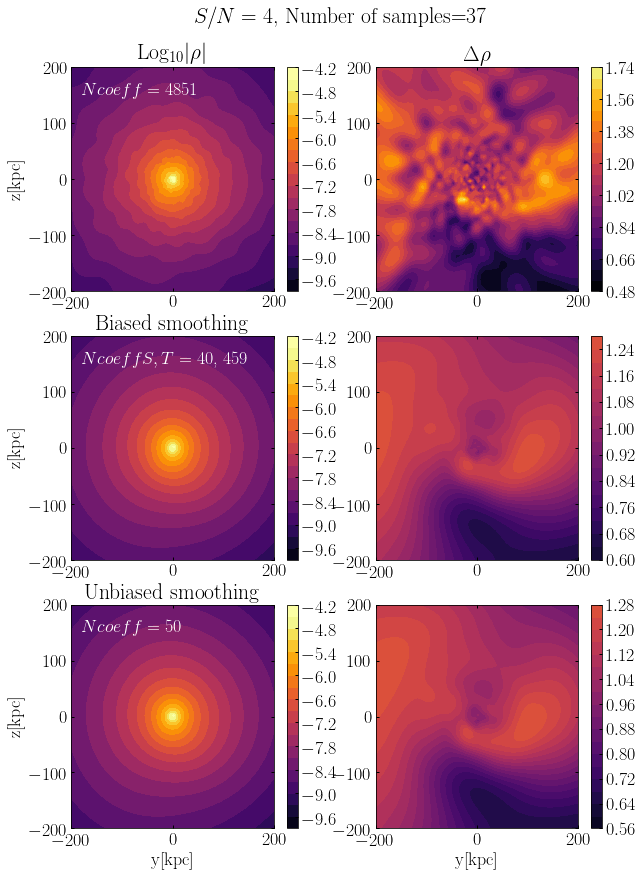

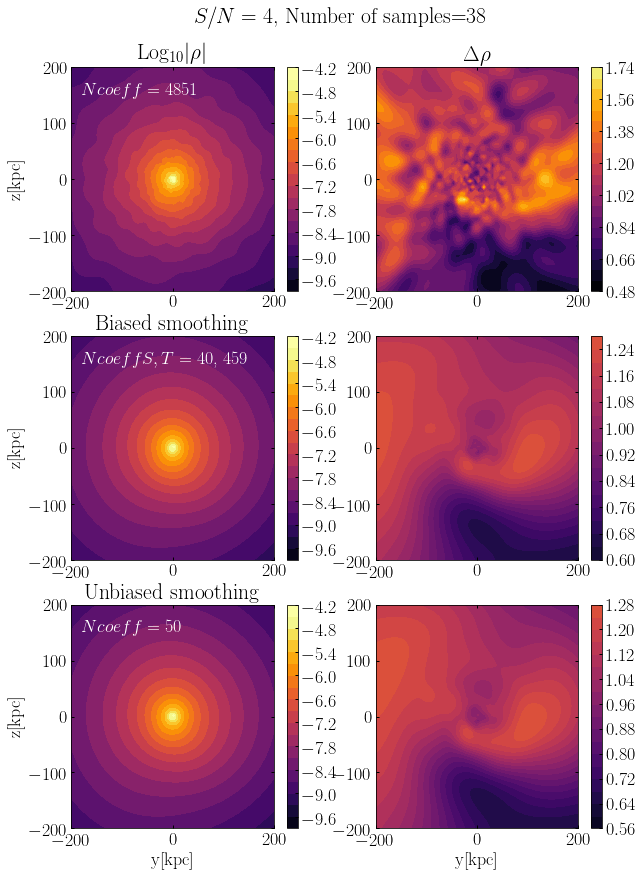

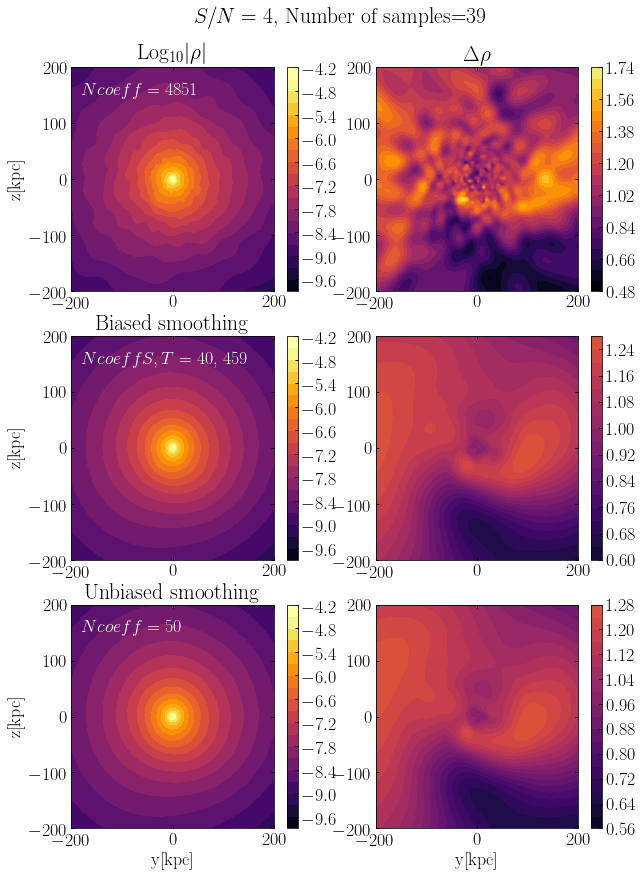

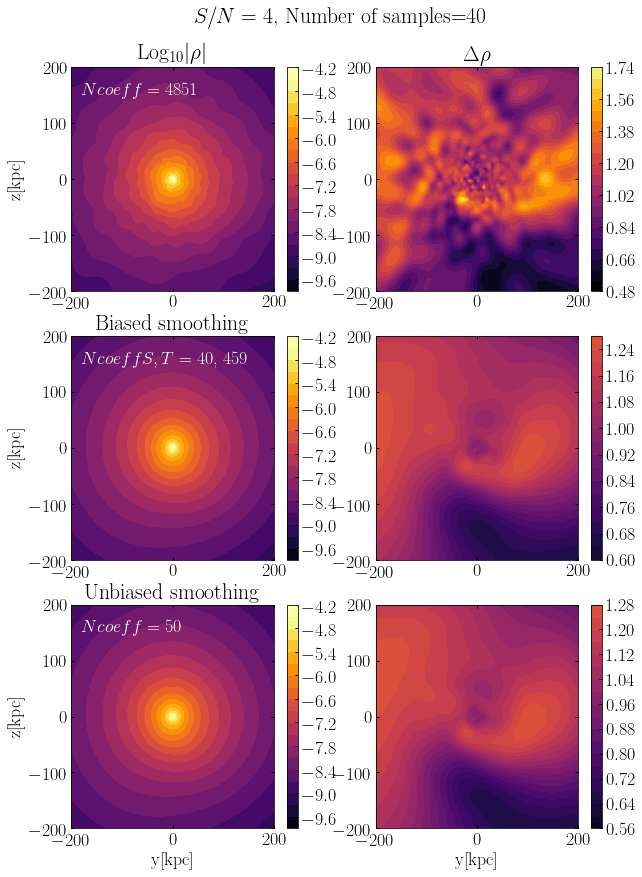

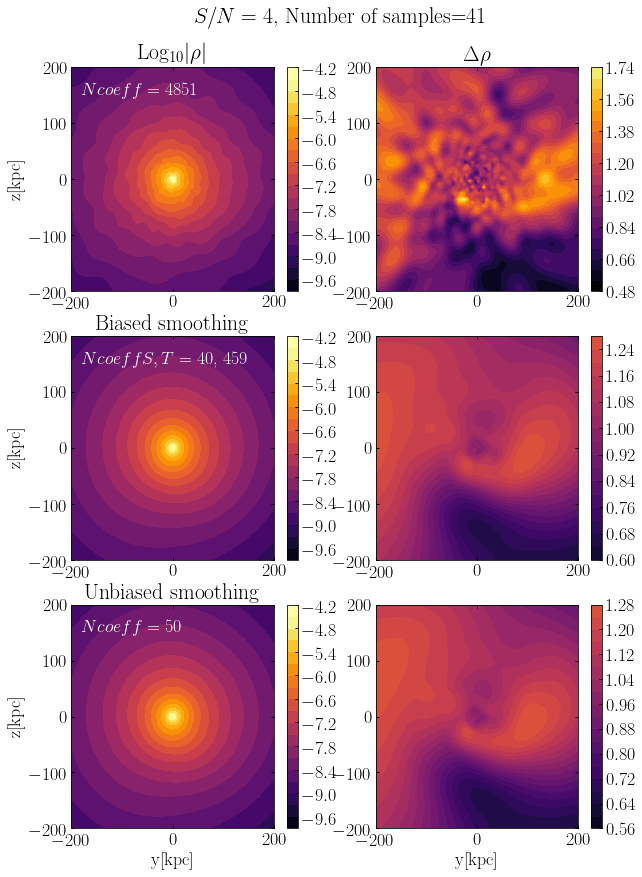

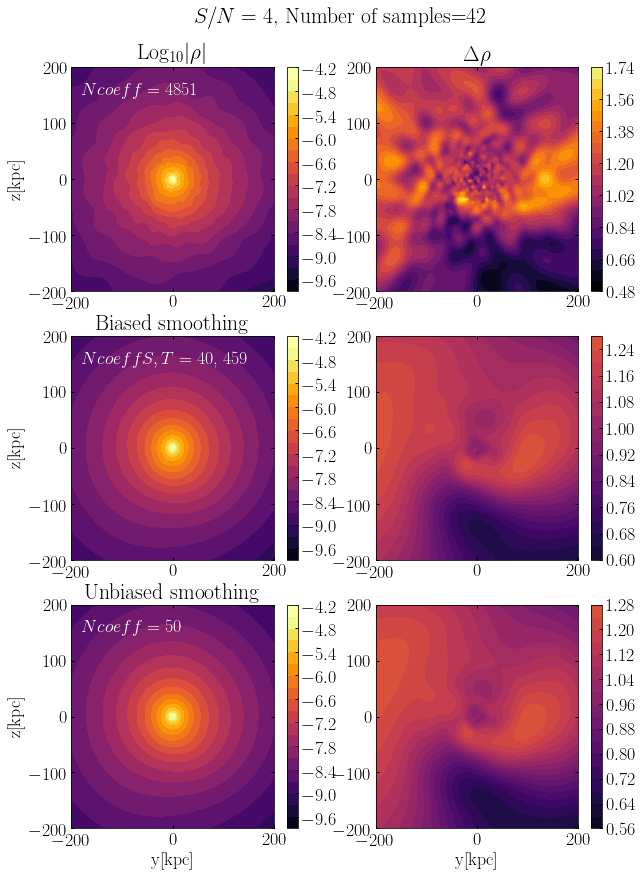

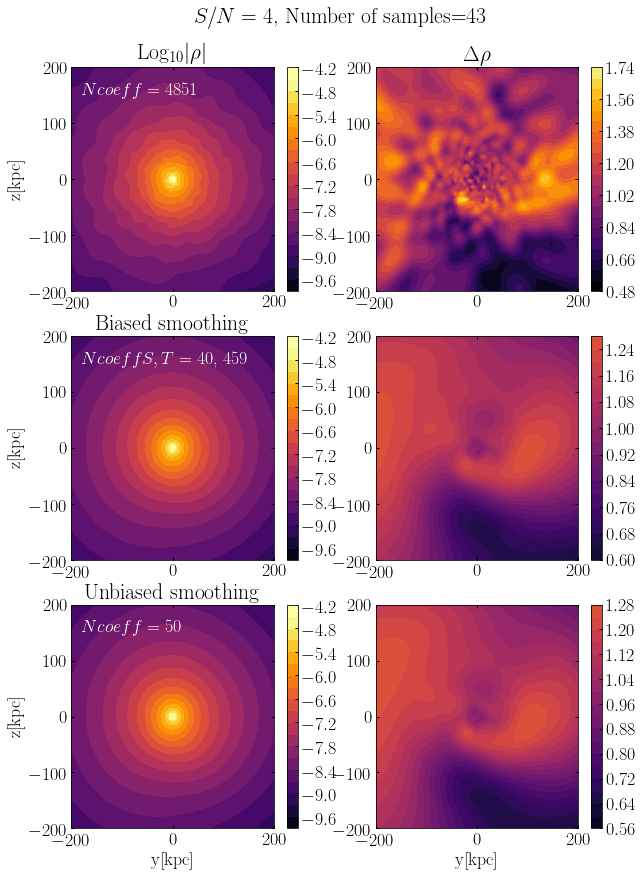

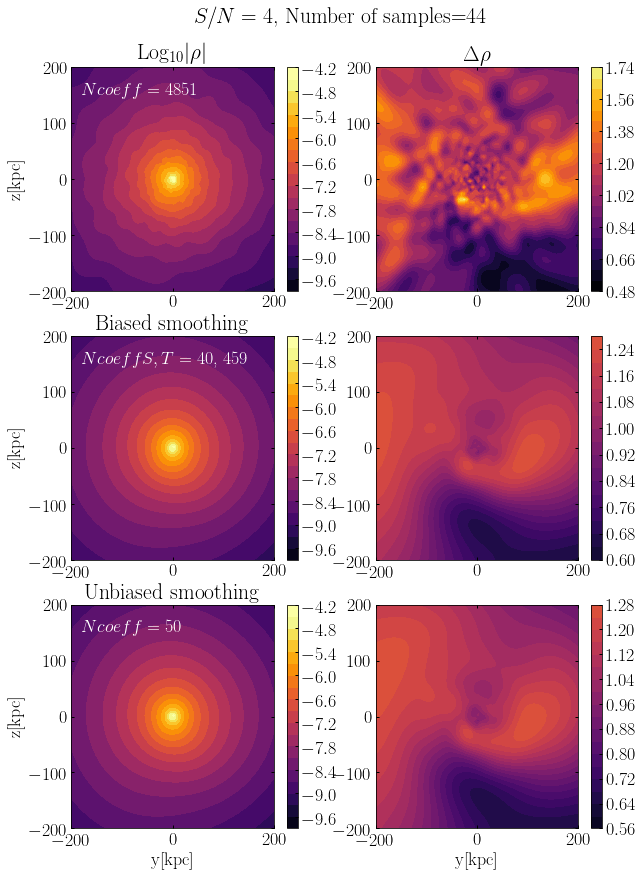

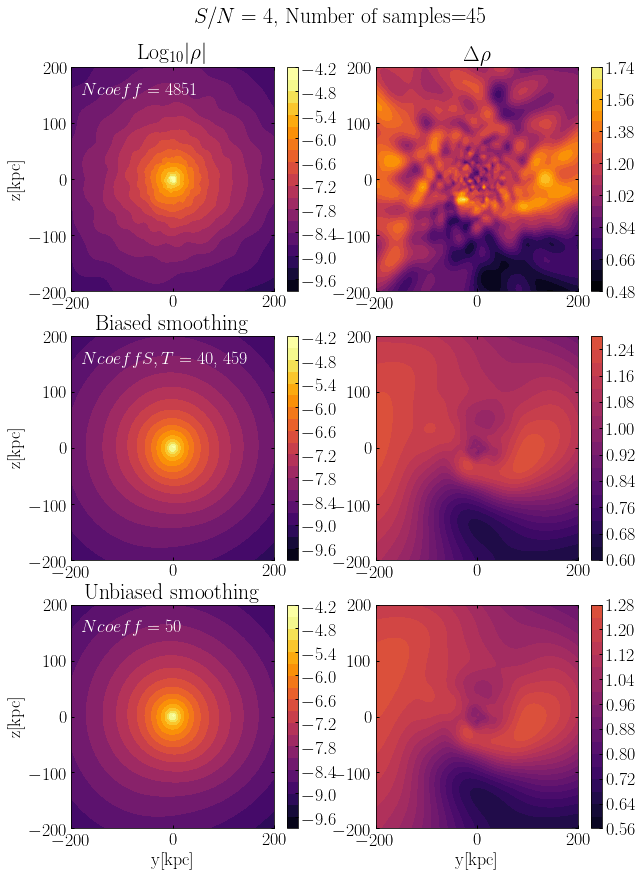

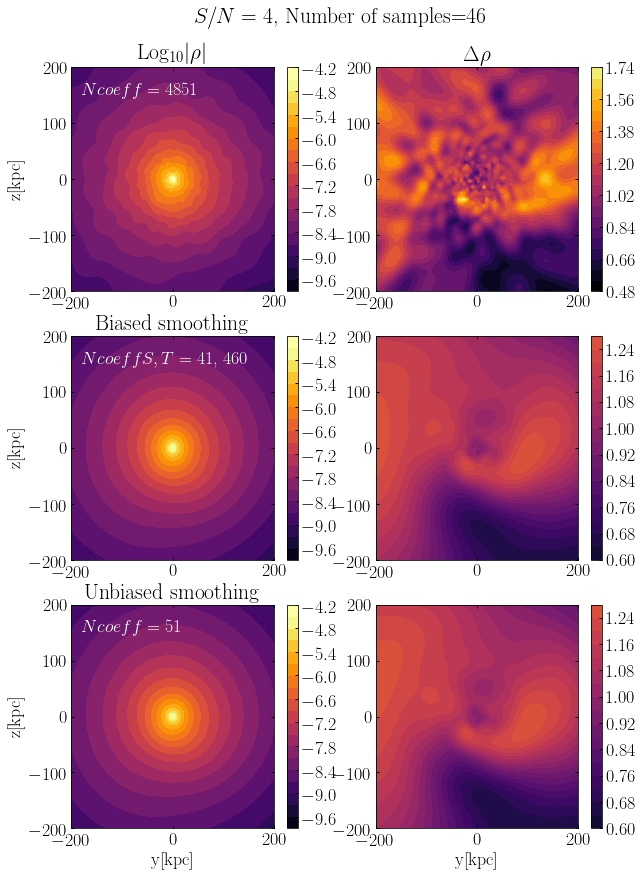

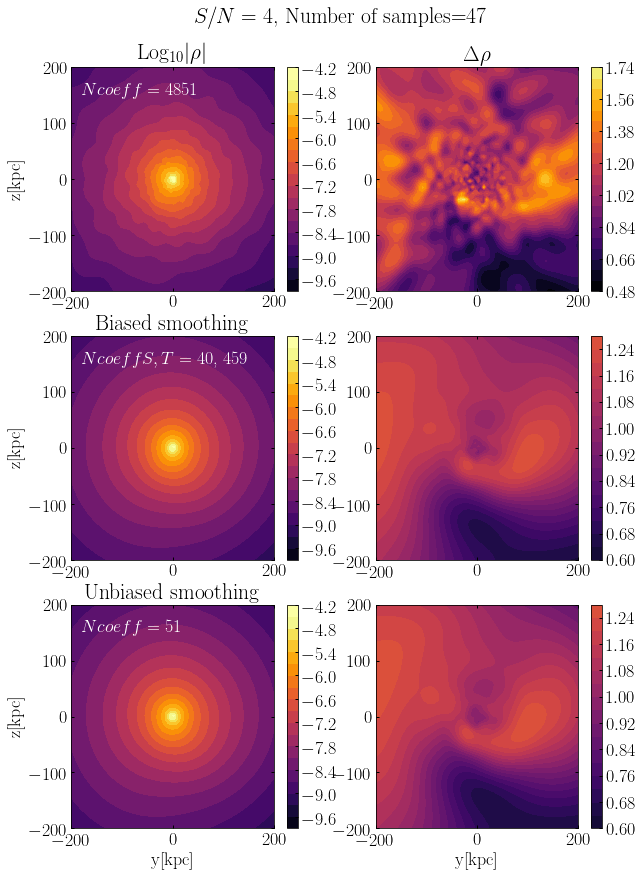

In [9]:
for i in range(1, 150):
    S, T = coefficients_smoothing.read_coeff_matrix('../data/bootstrap_mwlmc_1e6_b1_test/coeff_rand_mwlmc5_b1_2_1E6_00', i, 20, 20, 20, 0, i)
    SS, TT, ST = coefficients_smoothing.read_cov_elements('../data/bootstrap_mwlmc_1e6_b1_test/cov_matrix_rand_mwlmc5_b1_2_1E6_00', i, 20, 20, 20, 0, i)
    S_smooth, T_smooth, N_smooth = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 4)
    #S_biased, T_biased, N_S, N_T = coefficients_smoothing.smooth_coeff_matrix_biased(S, T, SS, TT, mass, 20,20,20, 4)


    S_000_smooth = np.zeros((1, 1, 1))
    T_000_smooth = np.zeros((1, 1, 1))
    S_000_smooth[0][0][0] = S_smooth[0][0][0]

    S_000_smooth_biased = np.zeros((1, 1, 1))
    T_000_smooth_biased = np.zeros((1, 1, 1))
    S_000_smooth_biased[0][0][0] = S_biased[0][0][0]

    S_000 = np.zeros((1, 1, 1))
    T_000 = np.zeros((1, 1, 1))
    S_000[0][0][0] = S[0][0][0]


    rho_all = biff.density(xyz, S_smooth, T_smooth, M=1, r_s=40.85)
    rho_base = biff.density(xyz, S_000_smooth, T_000_smooth, M=1, r_s=40.85)

    rho_all_bias = biff.density(xyz, S_biased, T_biased, M=1, r_s=40.85)
    rho_base_bias = biff.density(xyz, S_000_smooth_biased, T_000_smooth_biased, M=1, r_s=40.85)
    rho_all_ns = biff.density(xyz, S, T, M=1, r_s=40.85)
    rho_base_ns = biff.density(xyz, S_000, T_000, M=1, r_s=40.85)


    fig = figure(figsize=(10,14))
    fig.suptitle('$S/N=4$, Number of samples={}'.format(i) , y=0.94)
    subplot(3, 2, 1)
    title(r'$\rm{Log_{10}}|\rho|$')
    contourf(y_grid, z_grid, np.log10(rho_all_ns).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=-10, vmax=-4.5)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()

    text(-180, 150, '$Ncoeff=4851$', color='w')
    #text.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='white'),path_effects.Normal()])

    ylabel('z[kpc]')


    subplot(3, 2, 2)
    title(r'$\Delta \rho$')
    contourf(y_grid, z_grid, (rho_all_ns/rho_base_ns).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=0.5, vmax=1.78)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()

    subplot(3, 2, 3)
    title('Biased smoothing')

    contourf(y_grid, z_grid, np.log10(rho_all_bias).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=-10, vmax=-4.5)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    ylabel('z[kpc]')
    text(-180, 150, '$Ncoeff S, T=$ {}, {}'.format(N_S, N_T), color='w')


    #text = text(-150, 150, '$NS_{coeff}=$+{}')



    subplot(3, 2, 4)
    contourf(y_grid, z_grid, (rho_all_bias/rho_base_bias).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=0.5, vmax=1.78)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()


    subplot(3, 2, 5)
    title('Unbiased smoothing')
    contourf(y_grid, z_grid, np.log10(rho_all).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=-10, vmax=-4.5)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    xlabel('y[kpc]')
    ylabel('z[kpc]')
    text(-180, 150, '$Ncoeff =$ {}'.format(N_smooth), color='w')

    subplot(3, 2, 6)
    contourf(y_grid, z_grid, (rho_all/rho_base).reshape(bins, bins), 20,
             origin='lower', cmap='inferno', vmin=0.5, vmax=1.78)

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    xlabel('y[kpc]')

    savefig('N_samples_smoothening_SN_4_{:0>3d}.png'.format(i), bbox_inches='tight')

/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:98: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:179: RuntimeWarning: invalid value encountered in double_scalars
  SN_coeff_unc = (coeff**2/var_coeff)**0.5
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:171: RuntimeWarning: invalid value encountered in double_scalars
  b_nlm = 1/(1 + var_coeff/coeff**2)
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:98: RuntimeWarning: invalid value encountered in double_scalars
  bt = 

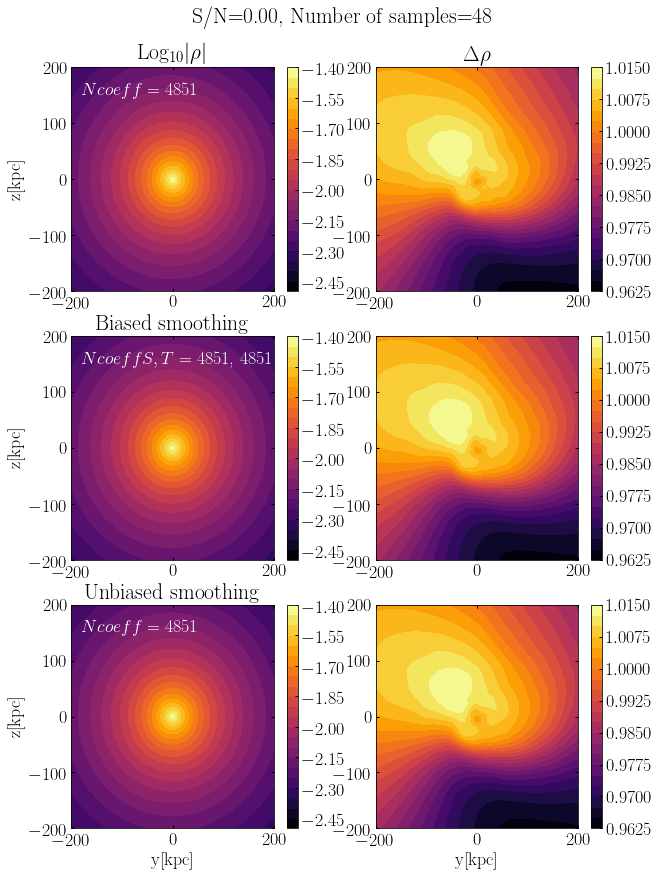

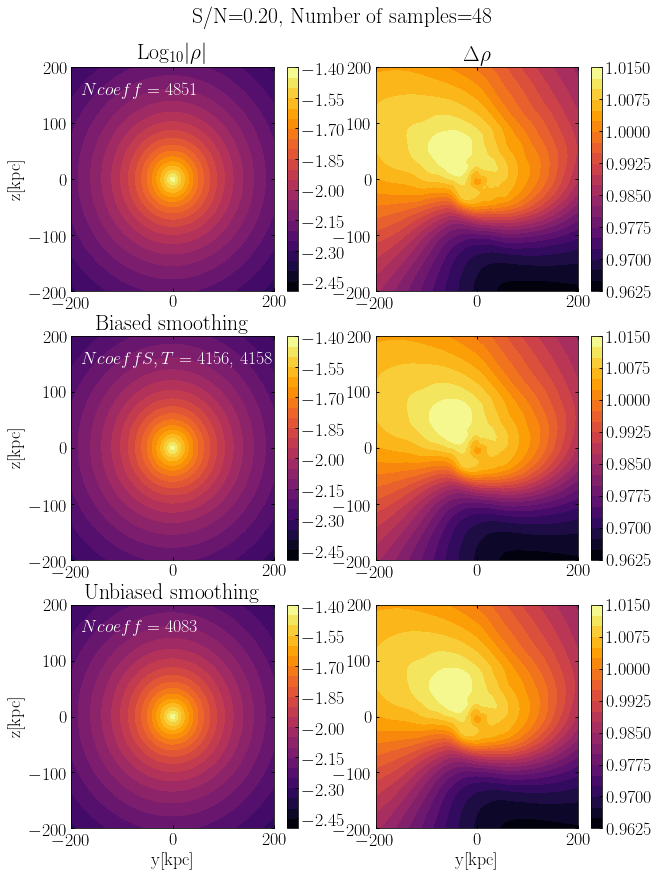

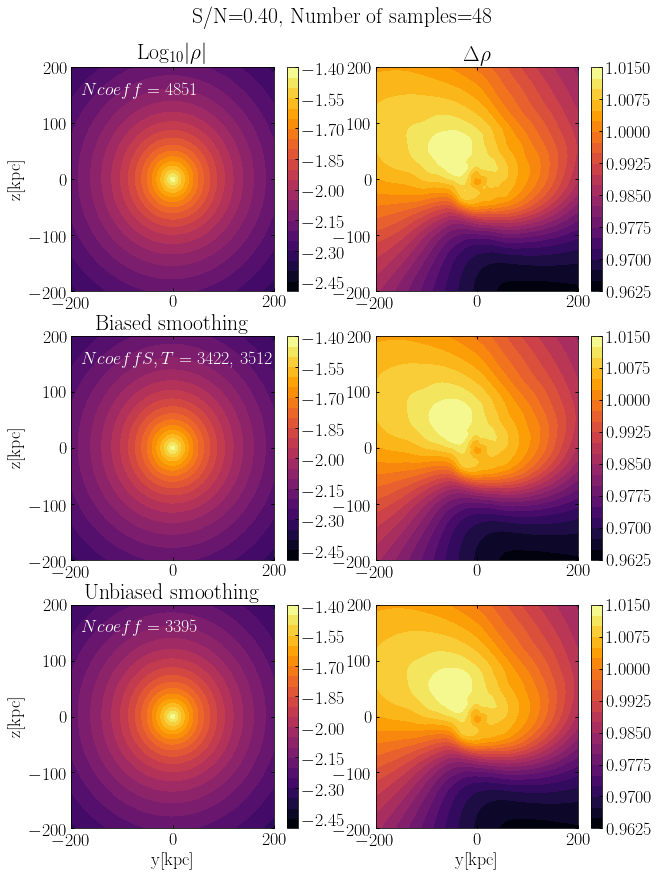

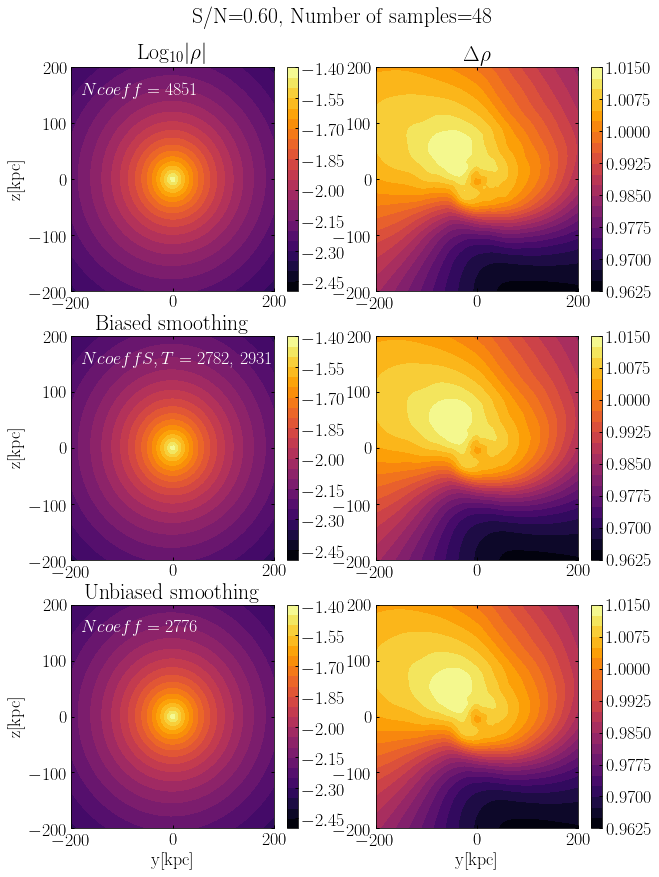

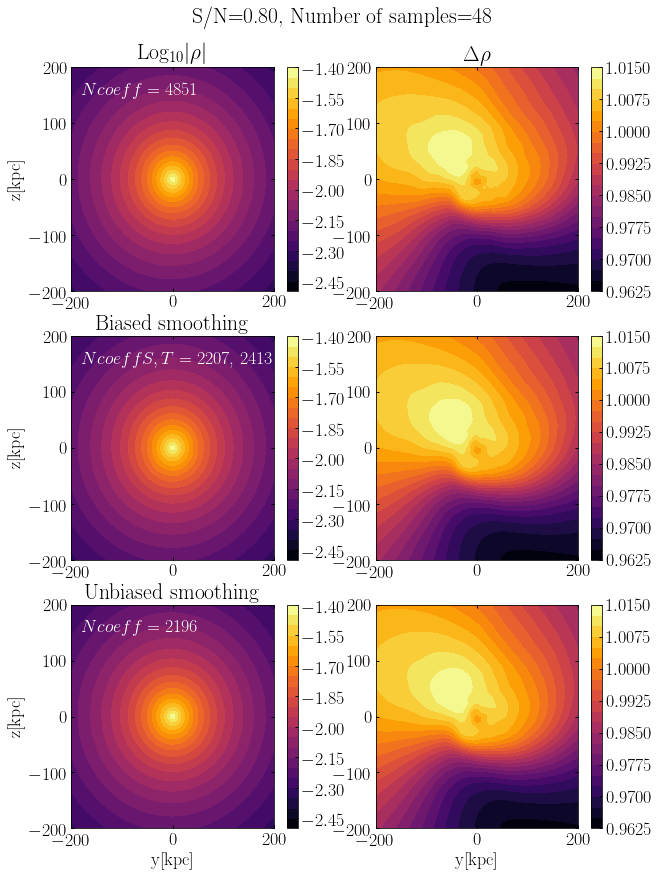

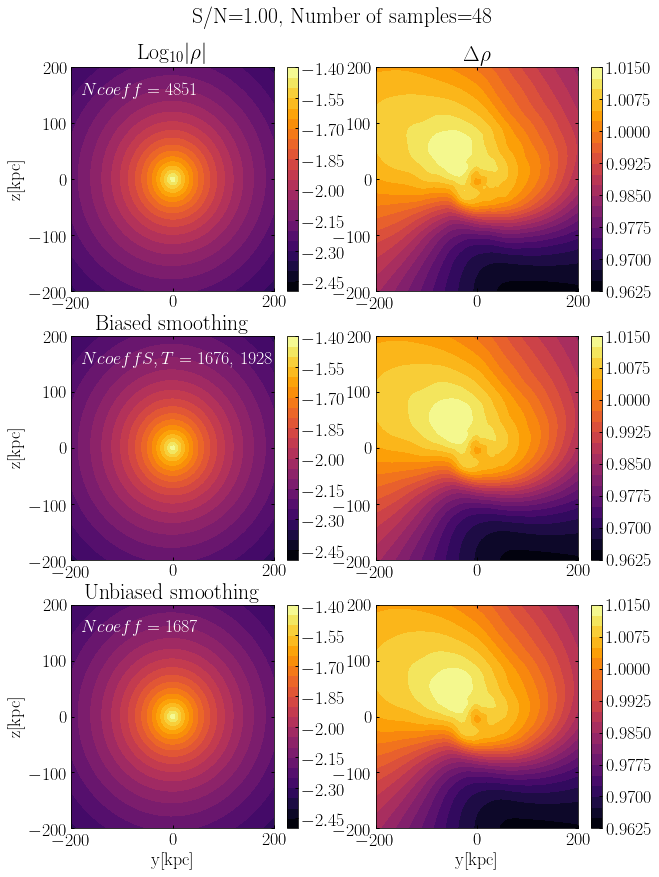

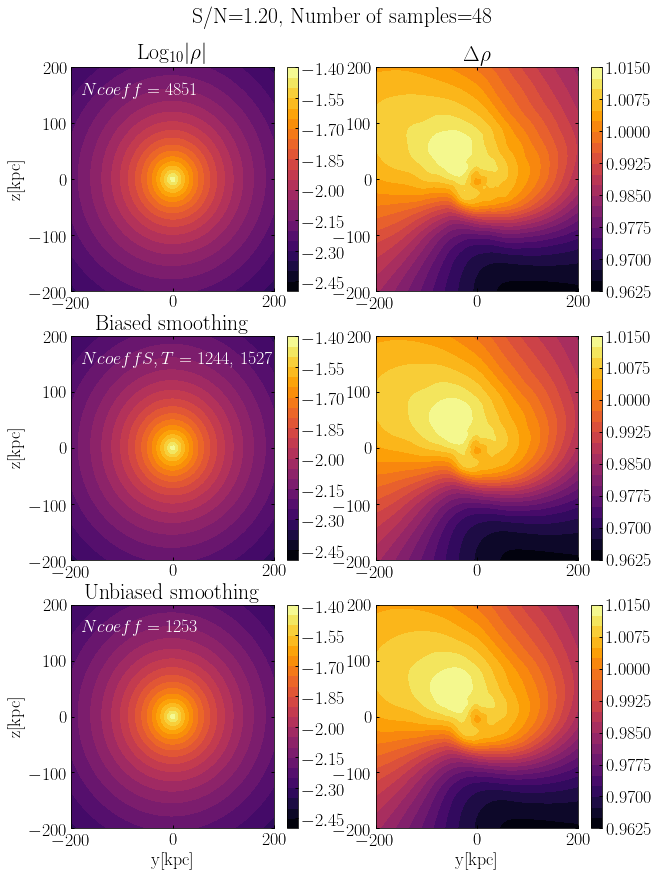

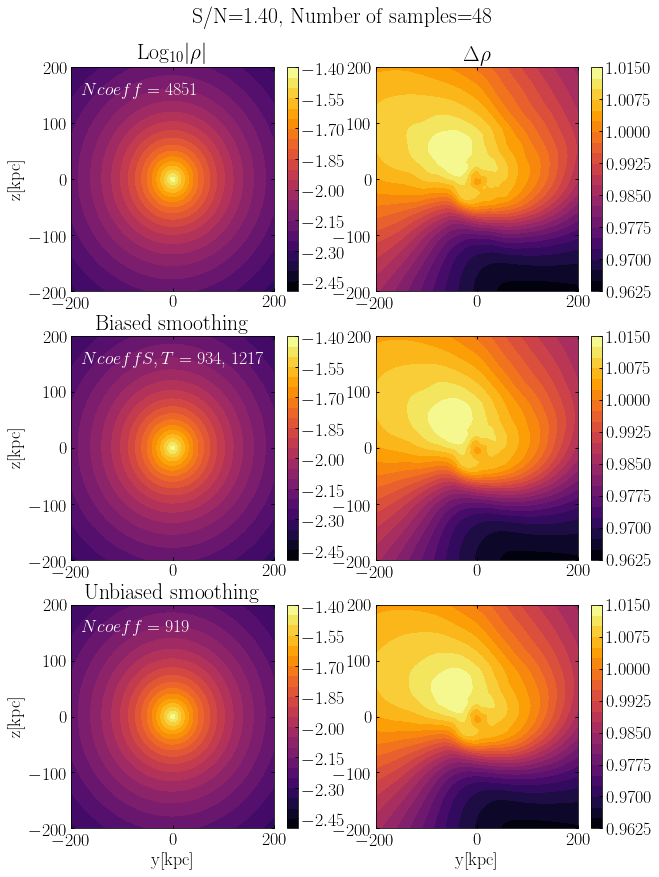

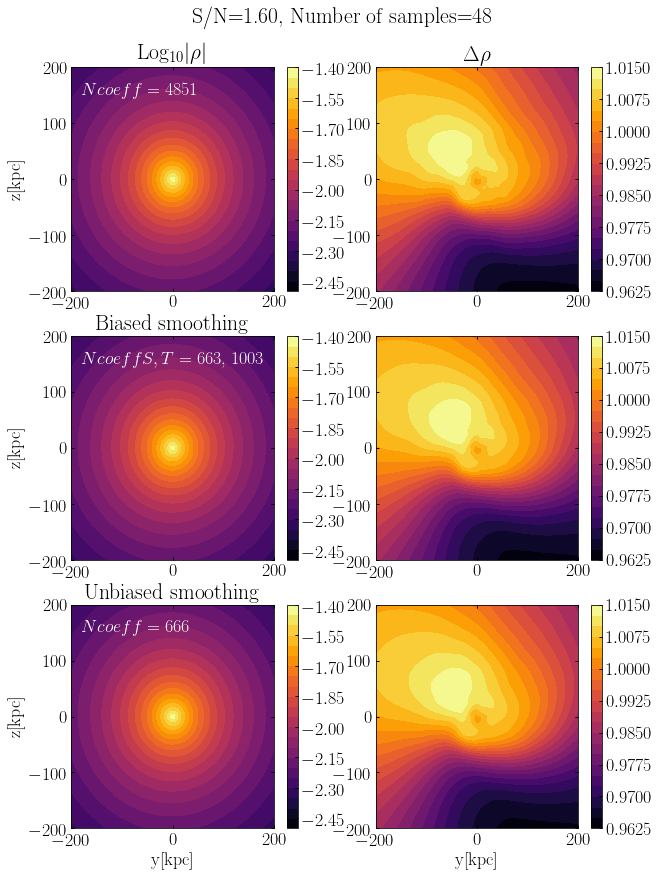

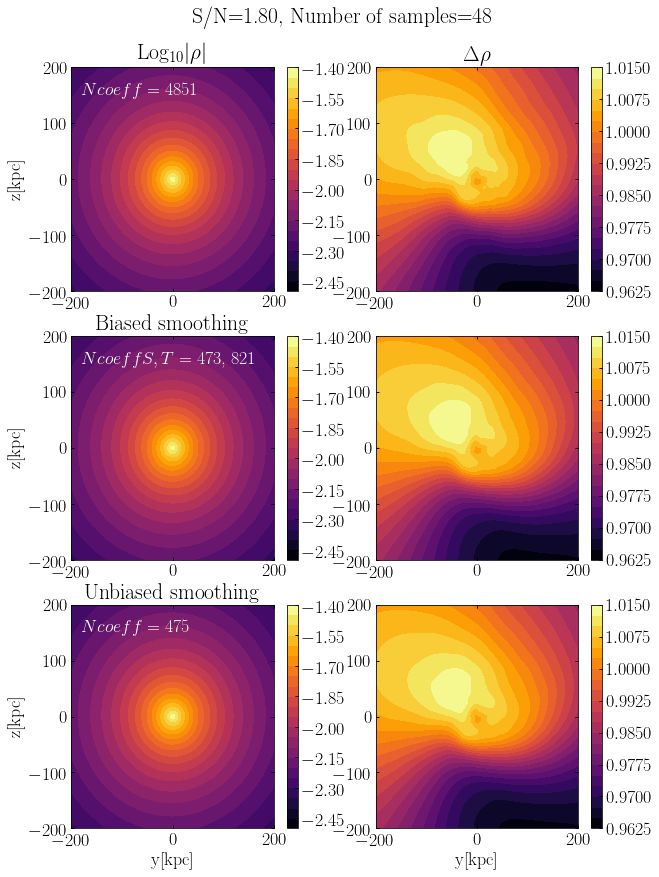

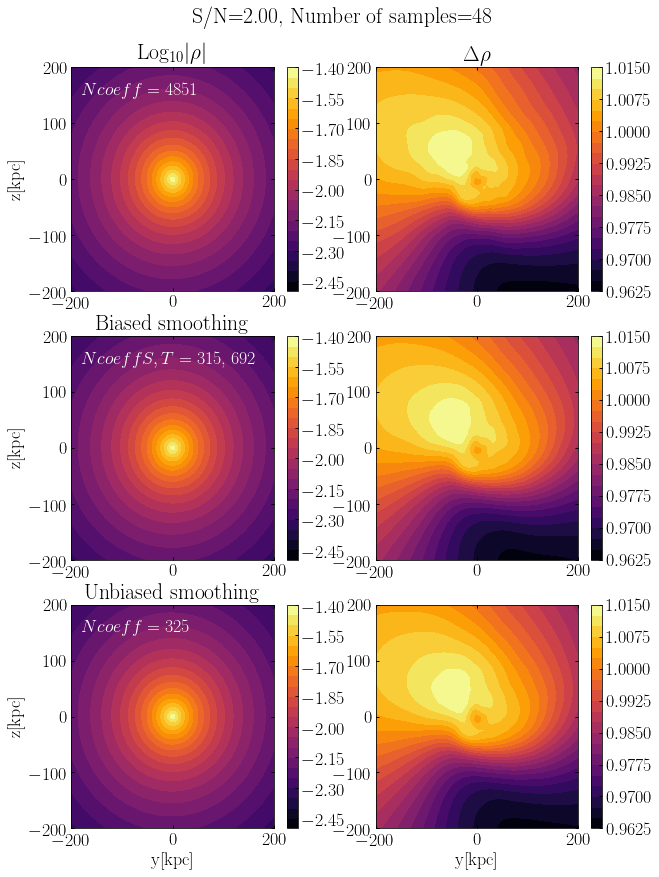

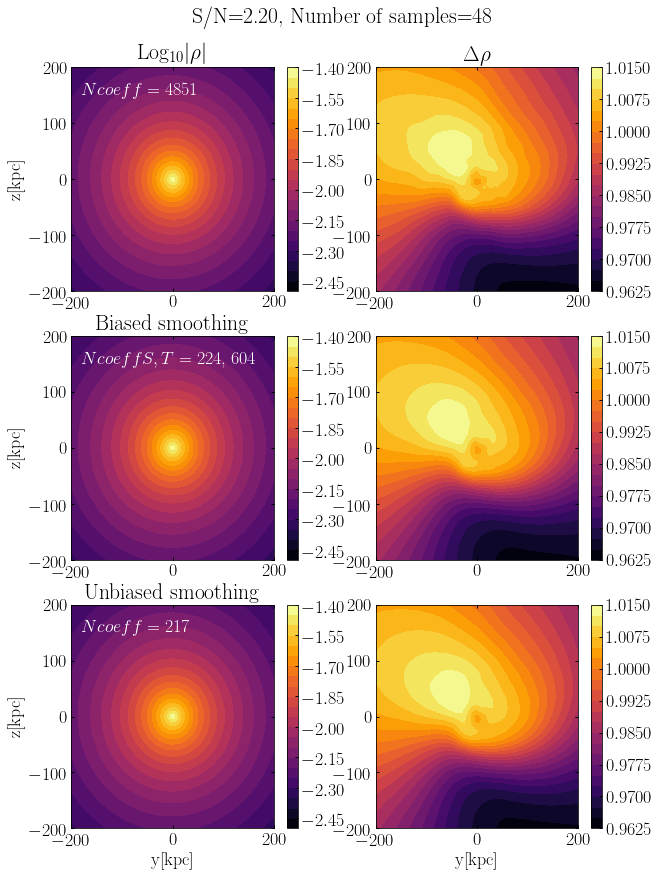

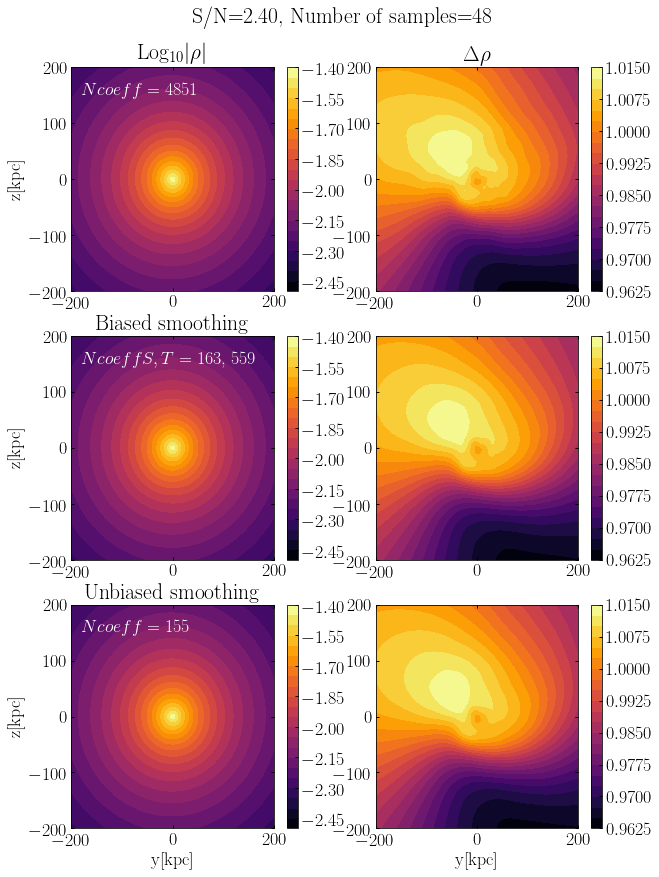

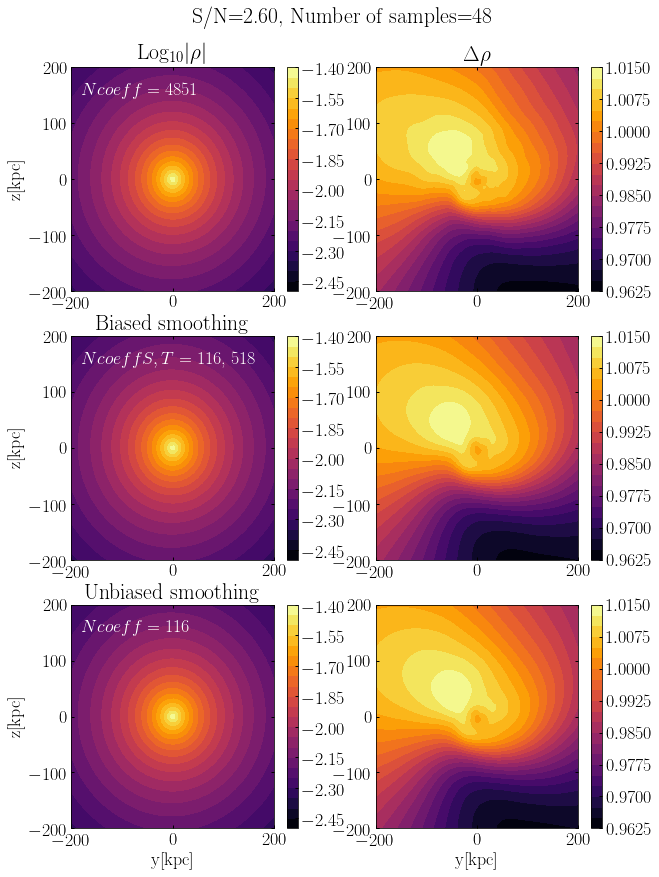

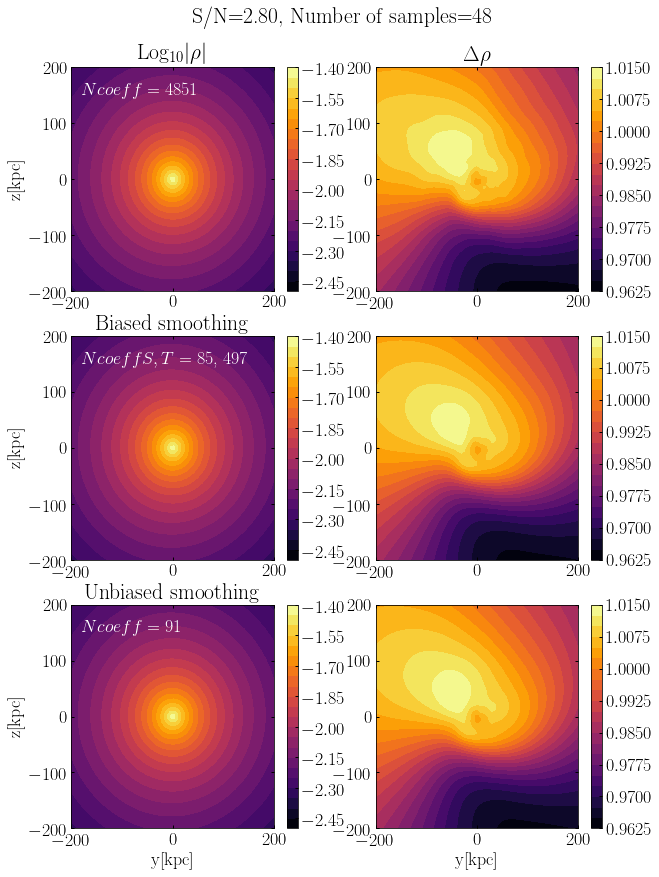

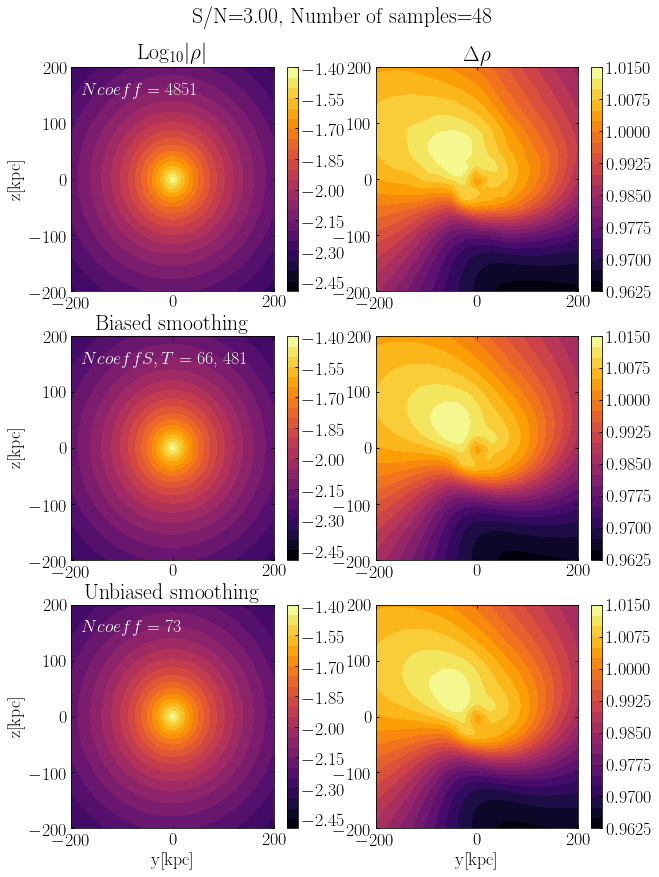

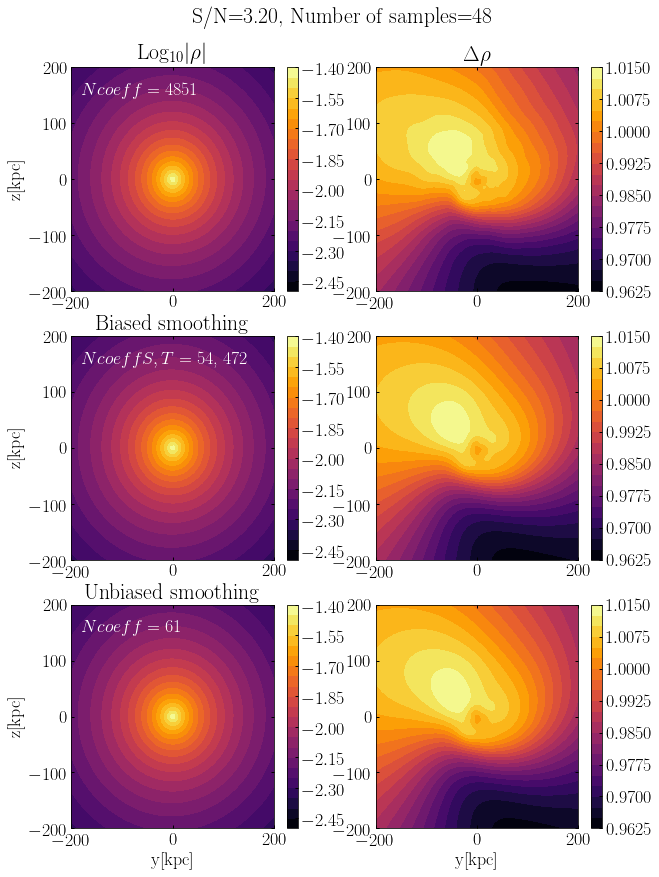

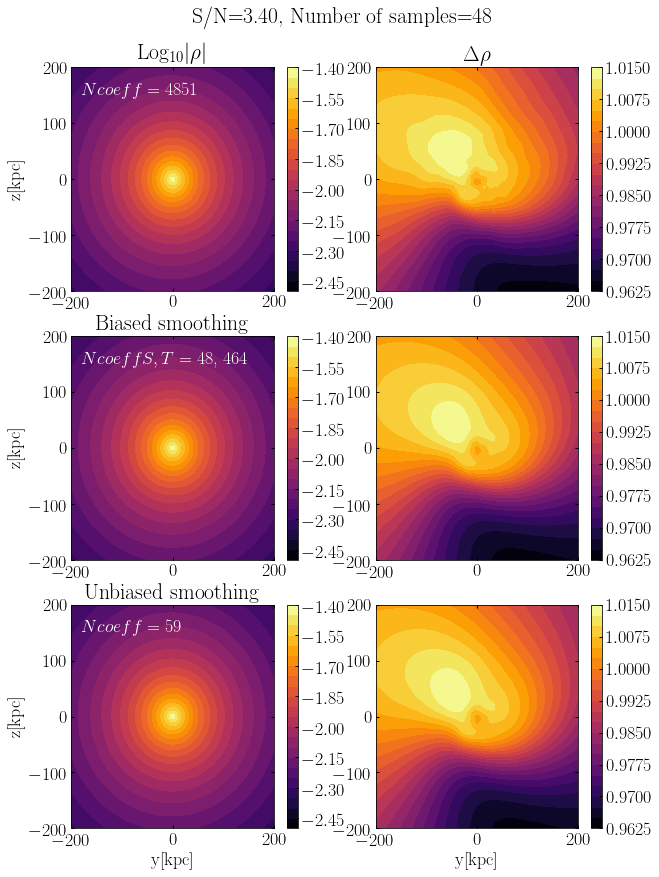

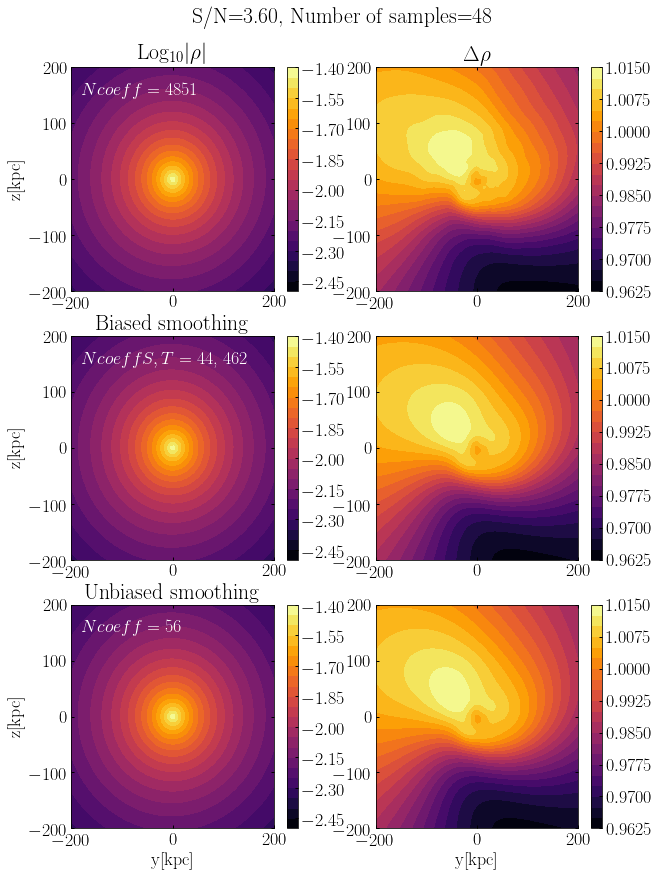

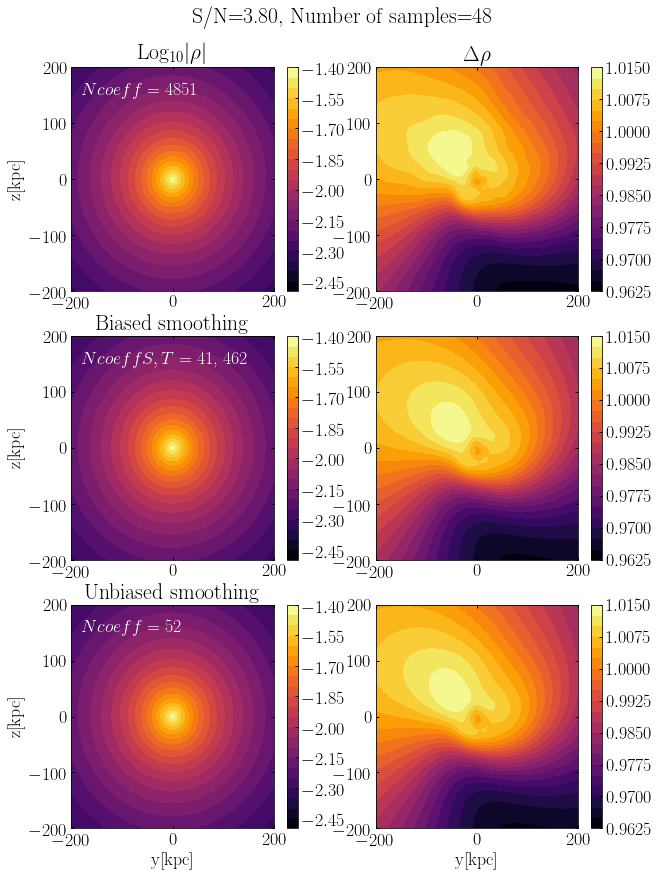

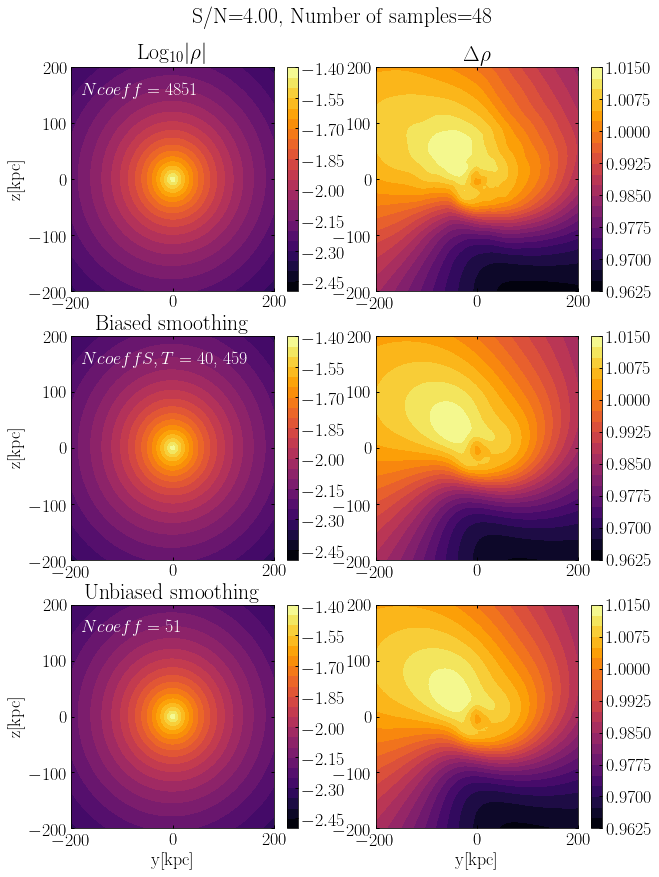

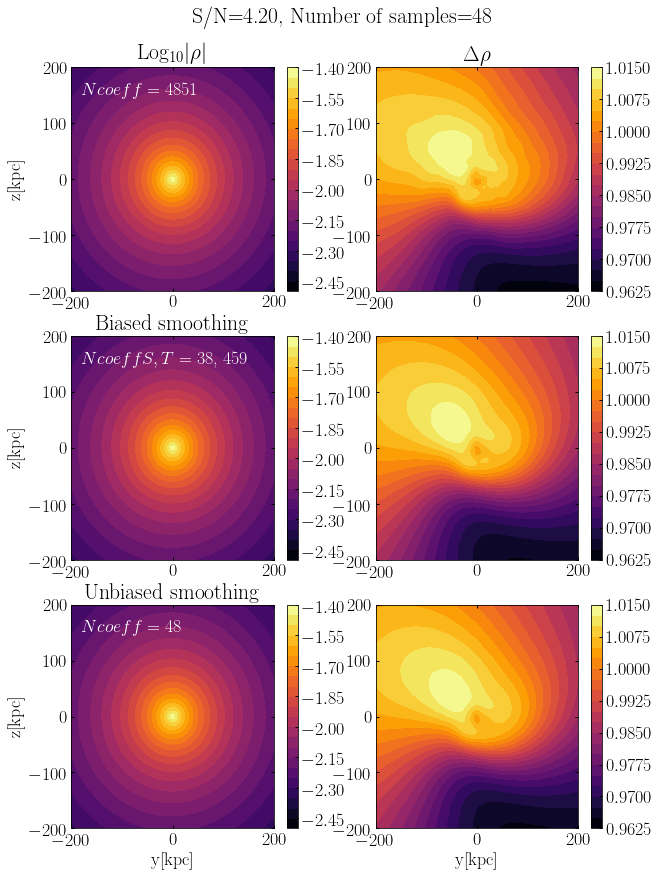

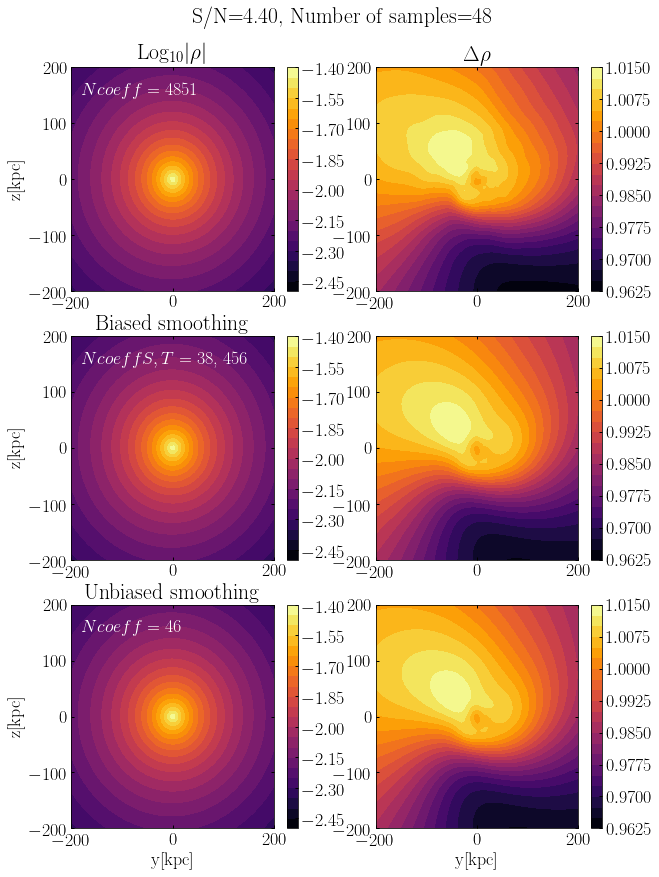

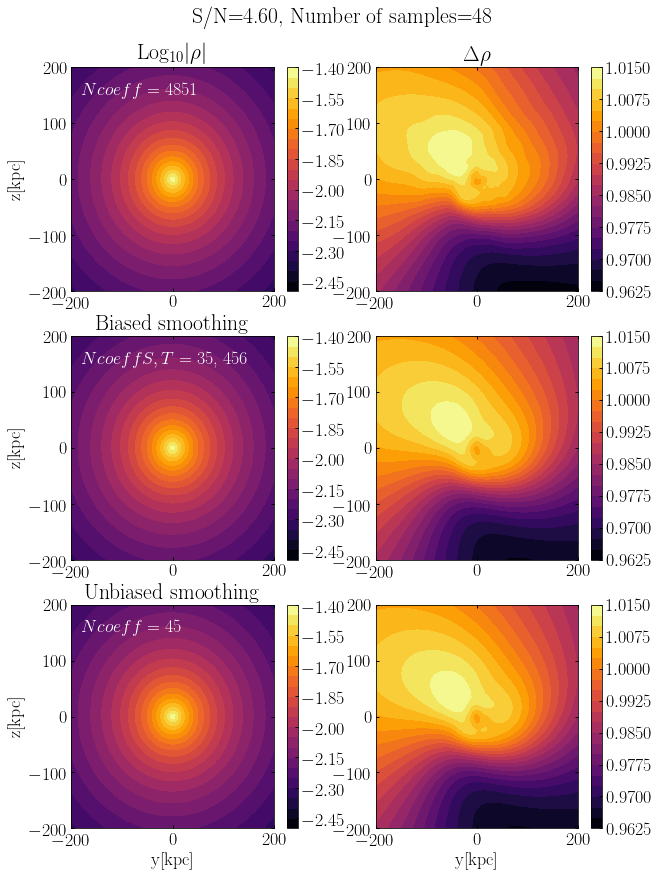

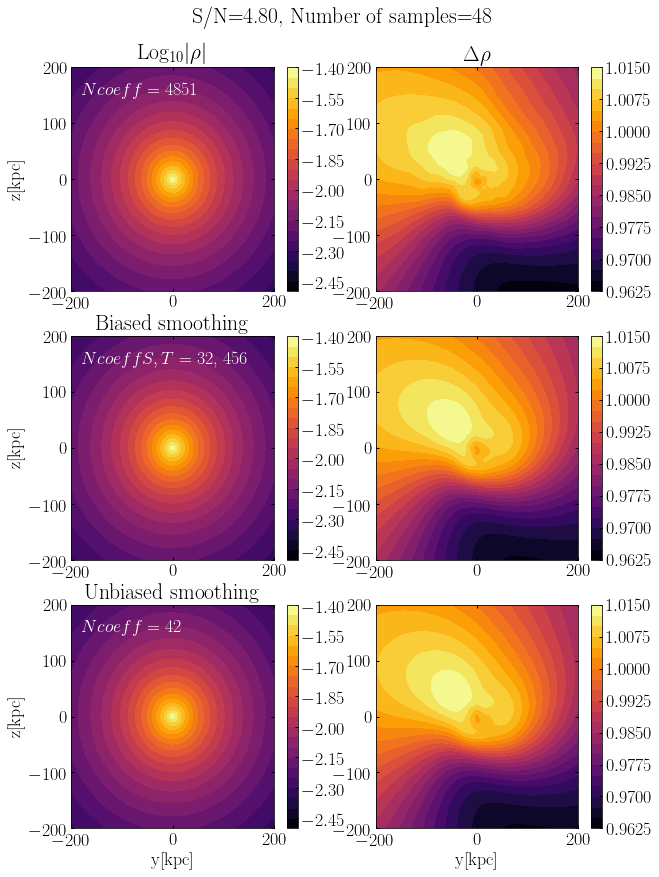

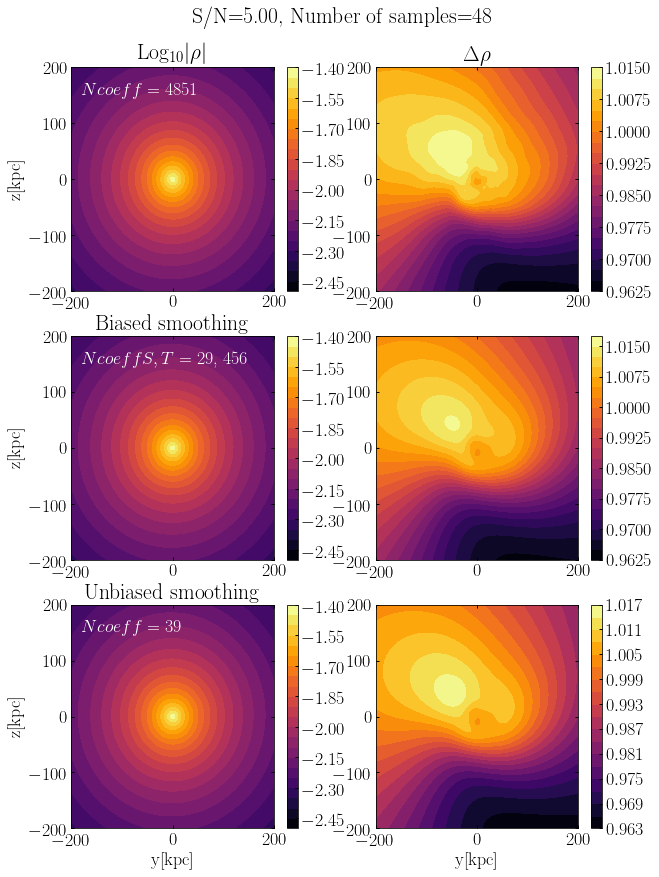

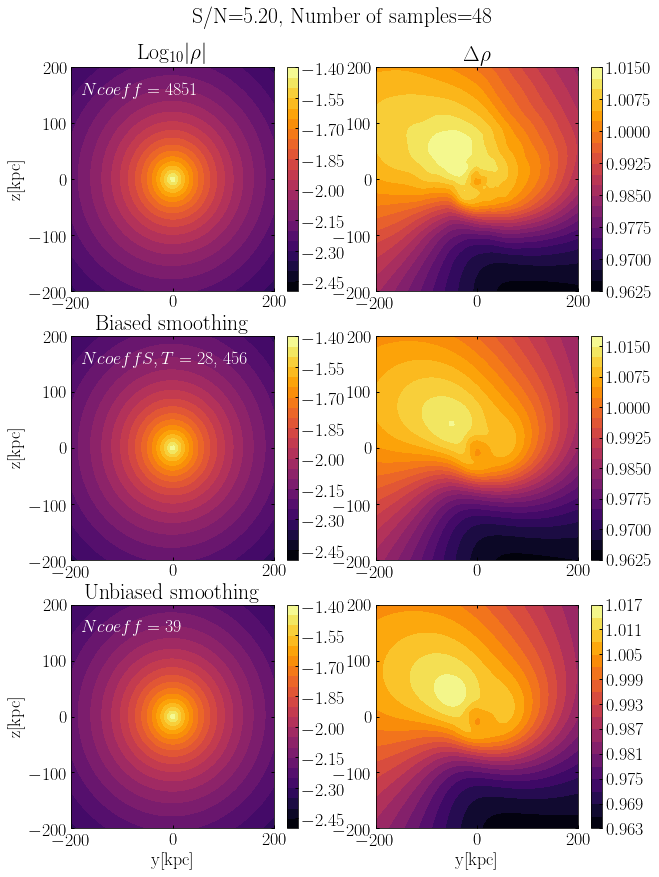

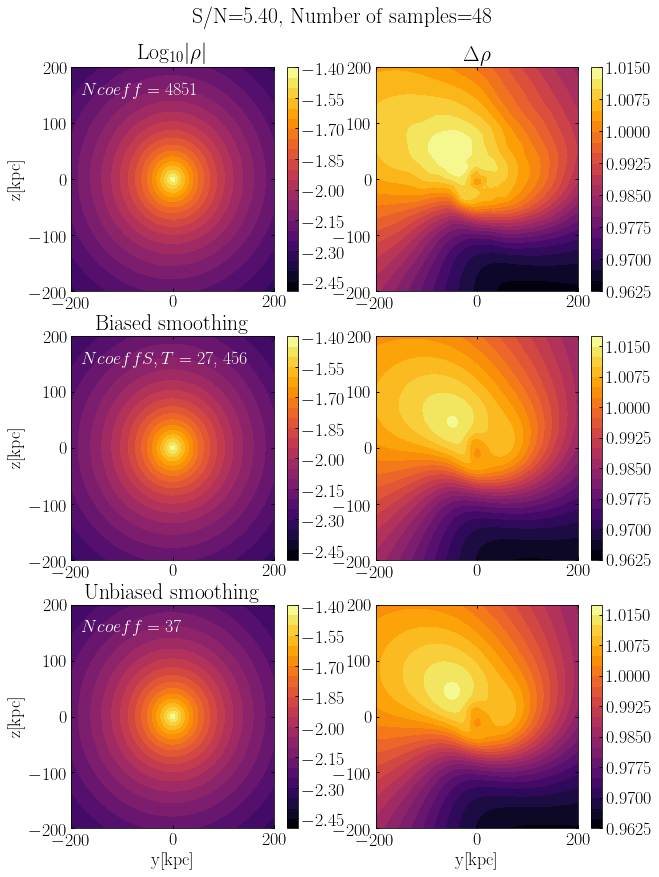

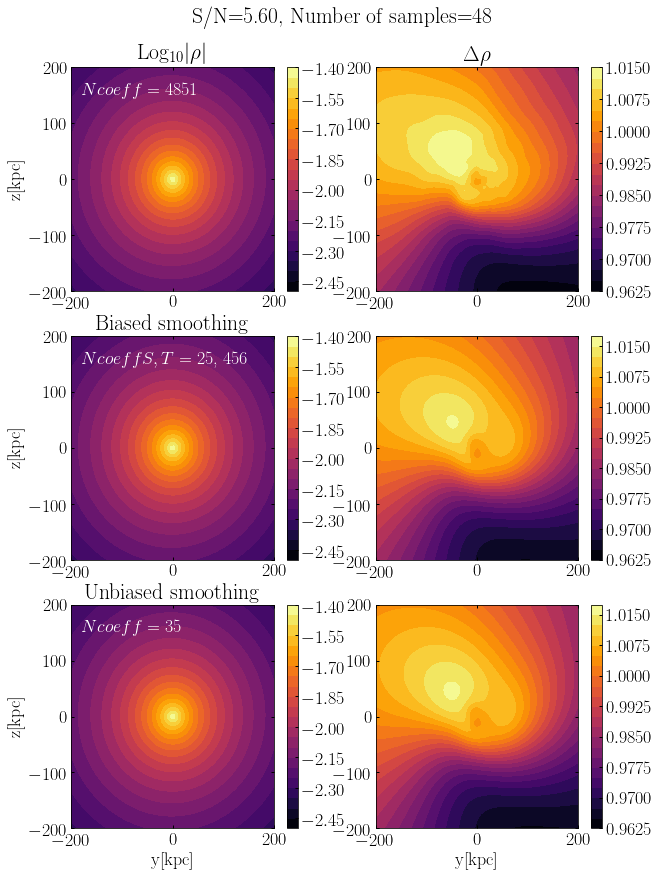

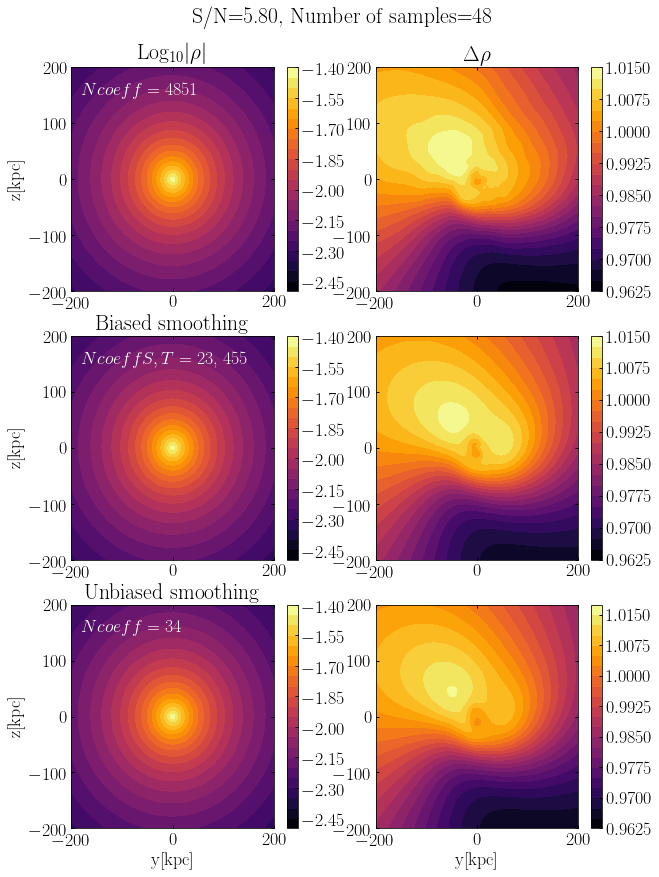

In [15]:
sn = np.arange(0, 6, 0.2)
for i in range(len(sn)):
    S, T = coefficients_smoothing.read_coeff_matrix('../data/bootstrap_mwlmc_1e6_b1_test/coeff_rand_mwlmc5_b1_2_1E6_00', 47, 20, 20, 20, 0, 47)
    SS, TT, ST = coefficients_smoothing.read_cov_elements('../data/bootstrap_mwlmc_1e6_b1_test/cov_matrix_rand_mwlmc5_b1_2_1E6_00', 47, 20, 20, 20, 0, 47)
    S_smooth, T_smooth, N_smooth = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, sn[i])
    S_biased, T_biased, N_S, N_T = coefficients_smoothing.smooth_coeff_matrix_biased(S, T, SS, TT, mass, 20,20,20, sn[i])


    S_000_smooth = np.zeros((1, 1, 1))
    T_000_smooth = np.zeros((1, 1, 1))
    S_000_smooth[0][0][0] = S_smooth[0][0][0]

    S_000_smooth_biased = np.zeros((1, 1, 1))
    T_000_smooth_biased = np.zeros((1, 1, 1))
    S_000_smooth_biased[0][0][0] = S_biased[0][0][0]

    S_000 = np.zeros((1, 1, 1))
    T_000 = np.zeros((1, 1, 1))
    S_000[0][0][0] = S[0][0][0]


    rho_all = biff.gradient(xyz, S_smooth, T_smooth, M=1, r_s=40.85, G=1)
    rho_base = biff.gradient(xyz, S_000_smooth, T_000_smooth, M=1, r_s=40.85, G=1)

    rho_all_bias = biff.gradient(xyz, S_biased, T_biased, M=1, r_s=40.85, G=1)
    rho_base_bias = biff.gradient(xyz, S_000_smooth_biased, T_000_smooth_biased, M=1, r_s=40.85, G=1)
    rho_all_ns = biff.gradient(xyz, S, T, M=1, r_s=40.85, G=1)
    rho_base_ns = biff.gradient(xyz, S_000, T_000, M=1, r_s=40.85, G=1)
    rho_all = np.sqrt(rho_all[0]**2 + rho_all[1]**2 + rho_all[2]**2)
    

    fig = figure(figsize=(10,14))
    fig.suptitle('S/N={:.2f}, Number of samples=48'.format(sn[i]) , y=0.94)
    subplot(3, 2, 1)
    title(r'$\rm{Log_{10}}|\rho|$')
    contourf(y_grid, z_grid, np.log10(np.abs(rho_all_ns)).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()

    text(-180, 150, '$Ncoeff=4851$', color='w')
    #text.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='white'),path_effects.Normal()])

    ylabel('z[kpc]')


    subplot(3, 2, 2)
    title(r'$\Delta \rho$')
    contourf(y_grid, z_grid, (rho_all_ns/rho_base_ns).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()

    subplot(3, 2, 3)
    title('Biased smoothing')

    contourf(y_grid, z_grid, np.log10(np.abs(rho_all_bias)).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    ylabel('z[kpc]')
    text(-180, 150, '$Ncoeff S, T=$ {}, {}'.format(N_S, N_T), color='w')


    #text = text(-150, 150, '$NS_{coeff}=$+{}')



    subplot(3, 2, 4)
    contourf(y_grid, z_grid, (rho_all_bias/rho_base_bias).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()


    subplot(3, 2, 5)
    title('Unbiased smoothing')
    contourf(y_grid, z_grid, np.log10(np.abs(rho_all)).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    xlabel('y[kpc]')
    ylabel('z[kpc]')
    text(-180, 150, '$Ncoeff =$ {}'.format(N_smooth), color='w')

    subplot(3, 2, 6)
    contourf(y_grid, z_grid, (rho_all/rho_base).reshape(bins, bins), 20,
             origin='lower', cmap='inferno')

    xlim(-200, 200)
    ylim(-200, 200)
    colorbar()
    xlabel('y[kpc]')

    savefig('N_samples_smoothening_pot_SN_{:0>3d}.png'.format(i), bbox_inches='tight')

In [98]:
#N_smooth = np.zeros(150)
N_smooth_SN_6 = np.zeros(150)
N_smooth_SN_5 = np.zeros(150)
N_smooth_SN_3 = np.zeros(150)
N_smooth_SN_2 = np.zeros(150)
N_smooth_SN_1 = np.zeros(150)
N_smooth_SN_0 = np.zeros(150)

for i in range(150, 151):
    S, T = coefficients_smoothing.read_coeff_matrix('../data/bootstrap_mwlmc_1e6_b1_test/coeff_rand_mwlmc5_b1_2_1E6_00', i, 20, 20, 20, 0, i)
    SS, TT, ST = coefficients_smoothing.read_cov_elements('../data/bootstrap_mwlmc_1e6_b1_test/cov_matrix_rand_mwlmc5_b1_2_1E6_00', i, 20, 20, 20, 0, i)
    #S_smooth, T_smooth, N_smooth_SN_6[i] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 6)
    #S_smooth, T_smooth, N_smooth_SN_5[i] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 5)
    #S_smooth, T_smooth, N_smooth_SN_3[i] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 3)
    #S_smooth, T_smooth, N_smooth_SN_2[i] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 2)
    #S_smooth, T_smooth, N_smooth_SN_1[i] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 1)
    S_smooth, T_smooth, N_smooth_SN_0[i-1] = coefficients_smoothing.smooth_coeff_matrix(S, T, SS, TT, ST, mass, 20, 20, 20, 4)

    #S_biased, T_biased, N_S, N_T = coefficients_smoothing.smooth_coeff_matrix_biased(S, T, SS, TT, mass, 20,20,20, 4)


/home/xzk/work/github/MW-LMC-SCF/code/coefficients_smoothing.py:98: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


In [25]:
n_samples = np.arange(1, 150, 1)

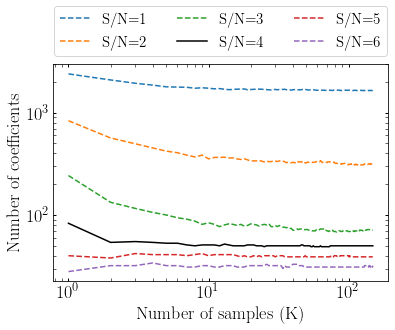

In [83]:
#plot(n_samples, N_smooth_SN_0[1:], label='S/N=0')
figure(figsize=(6, 4))
loglog(n_samples, N_smooth_SN_1[1:], label='S/N=1', c='C0', ls='--')
loglog(n_samples, N_smooth_SN_2[1:], label='S/N=2', c='C1', ls='--')
loglog(n_samples, N_smooth_SN_3[1:], label='S/N=3', c='C2', ls='--')
loglog(n_samples, N_smooth[1:], label='S/N=4', c='k', ls='-')
loglog(n_samples, N_smooth_SN_5[1:], label='S/N=5', c='C3', ls='--')
loglog(n_samples, N_smooth_SN_6[1:], label='S/N=6', c='C4', ls='--')

legend(bbox_to_anchor=(1.02, 1.3), ncol=3, fontsize=15)

xlabel('Number of samples (K)')
ylabel('Number of coefficients')
savefig('N_coeff_sample.pdf', bbox_inches='tight')

In [101]:
y_grid = np.arange(-300, 300, 5.5)
z_grid = np.arange(-300, 300, 5.5)
y_grid, z_grid = meshgrid(y_grid, z_grid)

xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())),
                                     y_grid.flatten(), z_grid.flatten()]).T)

In [102]:
rho_all = biff.density(xyz, S_smooth, T_smooth, M=1, r_s=40.85)


In [88]:
rho_all_normal = biff.density(xyz, S, T, M=1, r_s=40.85)


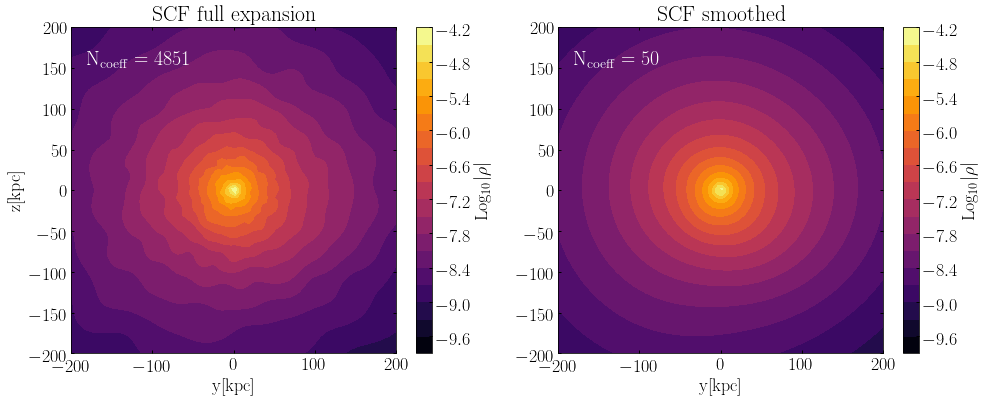

In [113]:
fig = figure(figsize=(16,6))

subplot(1, 2, 1)
title('SCF full expansion')
contourf(y_grid, z_grid, np.log10(np.abs(rho_all_normal)).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
cbar = colorbar()
cbar.set_label(r'$\rm{Log_{10}}|\rho|$')

text(-180, 150, r'$\rm{N}_{coeff}=4851$', color='w', fontsize=20)

ylabel('z[kpc]')
xlabel('y[kpc]')


subplot(1, 2, 2)
title('SCF smoothed')
contourf(y_grid, z_grid, np.log10(np.abs(rho_all)).reshape(bins, bins), 20,
         origin='lower', cmap='inferno')

xlim(-200, 200)
ylim(-200, 200)
cbar = colorbar()
cbar.set_label(r'$\rm{Log_{10}}|\rho|$')
xlabel('y[kpc]')

text(-180, 150, r'$\rm{N}_{coeff}=50$', color='w', fontsize=20)
savefig('density_smotthed_contours.pdf', bbox_inches='tight')